<a href="https://colab.research.google.com/github/danielantall/SonarHackathon/blob/models/SonarInference_Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install --upgrade datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)


In [40]:
!pip install python-dotenv

In [41]:
%%writefile bleu_rouge_evaluation.py

Overwriting bleu_rouge_evaluation.py


In [42]:
!pip install rouge-score pandas rouge

In [43]:
!pip install -q bert-score


In [44]:
import nltk, pathlib

# Ensure your custom directory is set up
custom_dir = pathlib.Path("/content/nltk_data")
custom_dir.mkdir(exist_ok=True)

if str(custom_dir) not in nltk.data.path:
    nltk.data.path.insert(0, str(custom_dir))

# Download both punkt and punkt_tab
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", download_dir=str(custom_dir))

try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    nltk.download("punkt_tab", download_dir=str(custom_dir))





In [45]:
import os, nltk
print("Exists:", os.path.exists("/root/nltk_data/tokenizers/punkt"))
print("Lookup :", nltk.data.find("tokenizers/punkt"))
print("  tab   :", nltk.data.find("tokenizers/punkt_tab"))



Exists: False
Lookup : /content/nltk_data/tokenizers/punkt
  tab   : /content/nltk_data/tokenizers/punkt_tab


## PREPROCESSING & CLEANING

In [46]:
# Imports

# dataset manipulation and math
import polars as pl
from datasets import load_dataset
import numpy as np

# ml
from sklearn.model_selection import train_test_split

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os
import json
import requests
from tqdm import tqdm
from datetime import datetime
import time

# metrics
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from bert_score import BERTScorer
import torch
import pandas as pd


In [47]:
from dotenv import load_dotenv
load_dotenv("env")
my_api_key = os.getenv("api_key")
print("Approved.")

Approved.


In [48]:
# Setup Reusable Code for Logging

# to see the cleaning visuals for analysis
os.makedirs("cleaning_visualizations", exist_ok=True)
os.makedirs("sonar_evaluation", exist_ok=True)

# Set up logging format
def log_section(title):
    print(f" {title} ".center(80, "="))

# each step in the log (ex. Loading dataset)
def log_step(step_name):
    print(f"\n--- {step_name} ---\n")

# log each metric as needed
def log_metric(name, value):
    print(f"  • {name}: {value}")

# compare before and after step to analyze difference
def log_comparison(name, before, after, unit="rows"):
    diff = after - before if isinstance(before, (int, float)) else 0
    diff_percent = (diff / before * 100) if before > 0 else 0
    if diff < 0:
        print(f"  • {name}: {before:,} → {after:,} {unit} ({abs(diff):,} removed, {abs(diff_percent):.2f}% reduction)")
    else:
        print(f"  • {name}: {before:,} → {after:,} {unit} ({diff:,} added, {diff_percent:.2f}% increase)")

In [49]:
# Load dataset and analyze nulls

# Load Dataset
log_section("Dataset Loading")
log_step("Load the Mental Health Dataset from HuggingFace")

ds = load_dataset("ShenLab/MentalChat16K")
# copy the data
all_data = pl.DataFrame(ds["train"][:])

log_metric("Total examples", all_data.shape[0])
log_metric("Columns", all_data.columns)
log_metric("Data types", all_data.dtypes)

# Check for null values in original dataset
null_counts = {
    "instruction": all_data.filter(pl.col("instruction").is_null()).shape[0],
    "input": all_data.filter(pl.col("input").is_null()).shape[0],
    "output": all_data.filter(pl.col("output").is_null()).shape[0]
}

# analyze the nulls
log_step("Null value analysis")
for col, count in null_counts.items():
    log_metric(f"Null values in '{col}'", f"{count:,} ({count/all_data.shape[0]*100:.2f}%)")

=============================== Dataset Loading ================================

--- Load the Mental Health Dataset from HuggingFace ---

  • Total examples: 16084
  • Columns: ['instruction', 'input', 'output']
  • Data types: [String, String, String]

--- Null value analysis ---

  • Null values in 'instruction': 0 (0.00%)
  • Null values in 'input': 27 (0.17%)
  • Null values in 'output': 0 (0.00%)


In [50]:
# Train-Test Split

# Split Dataset
log_section("Train/Test/Val Split")
log_step("Creating data splits in the dataset")

# 80% train, 20% test
train_df, temp_df = train_test_split(all_data, test_size=0.2, random_state=42)
#subsplit within test; now 10% test and 10% val (for hyperparameter tuning)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

log_metric("Training set size", f"{train_df.shape[0]:,} ({train_df.shape[0]/all_data.shape[0]*100:.1f}%)")
log_metric("Validation set size", f"{val_df.shape[0]:,} ({val_df.shape[0]/all_data.shape[0]*100:.1f}%)")
log_metric("Test set size", f"{test_df.shape[0]:,} ({test_df.shape[0]/all_data.shape[0]*100:.1f}%)")


============================= Train/Test/Val Split =============================

--- Creating data splits in the dataset ---

  • Training set size: 12,867 (80.0%)
  • Validation set size: 1,608 (10.0%)
  • Test set size: 1,609 (10.0%)


=========================== Analysis Of Text Length ============================

--- Calculating text length statistics to treat potential outliers ---


--- Instruction length statistics ---

  • min: 227
  • max: 227
  • mean: 227.0
  • median: 227.0
  • p05: 227.0
  • p95: 227.0

--- Input length statistics ---

  • min: 8
  • max: 7,284
  • mean: 586.9
  • median: 392.0
  • p05: 227.0
  • p95: 1750.0

--- Output length statistics ---

  • min: 213
  • max: 12,275
  • mean: 2060.4
  • median: 2166.0
  • p05: 574.0
  • p95: 3159.0

--- Generating length distribution visualizations ---

  • Instruction length distribution saved: cleaning_visualizations/instruction_length_distribution.png


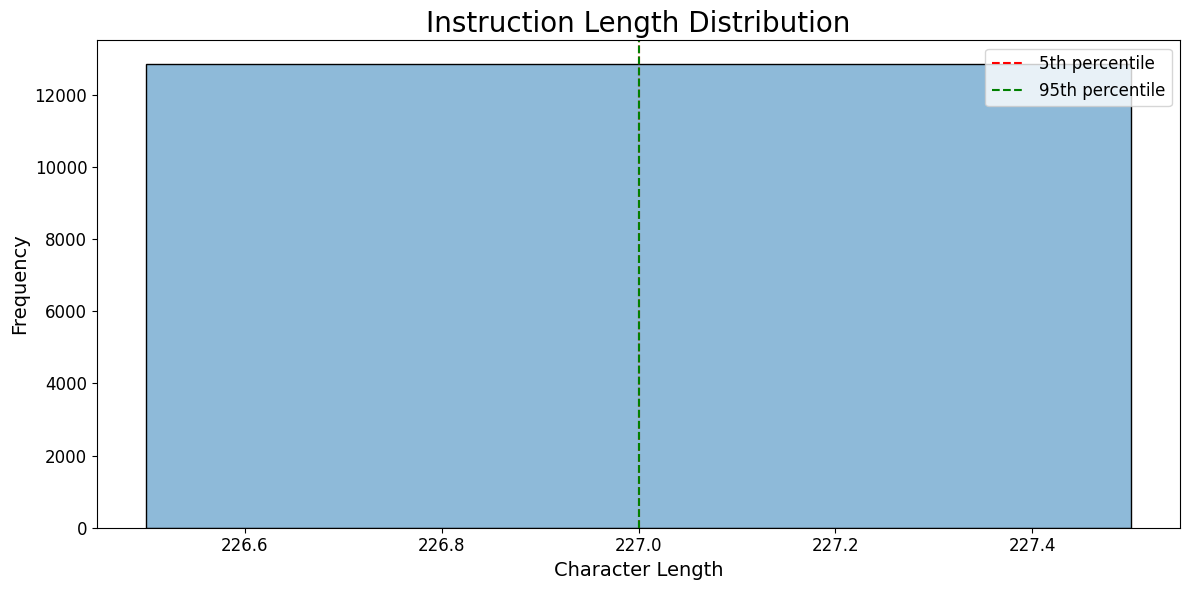

  • Input length distribution saved: cleaning_visualizations/input_length_distribution.png


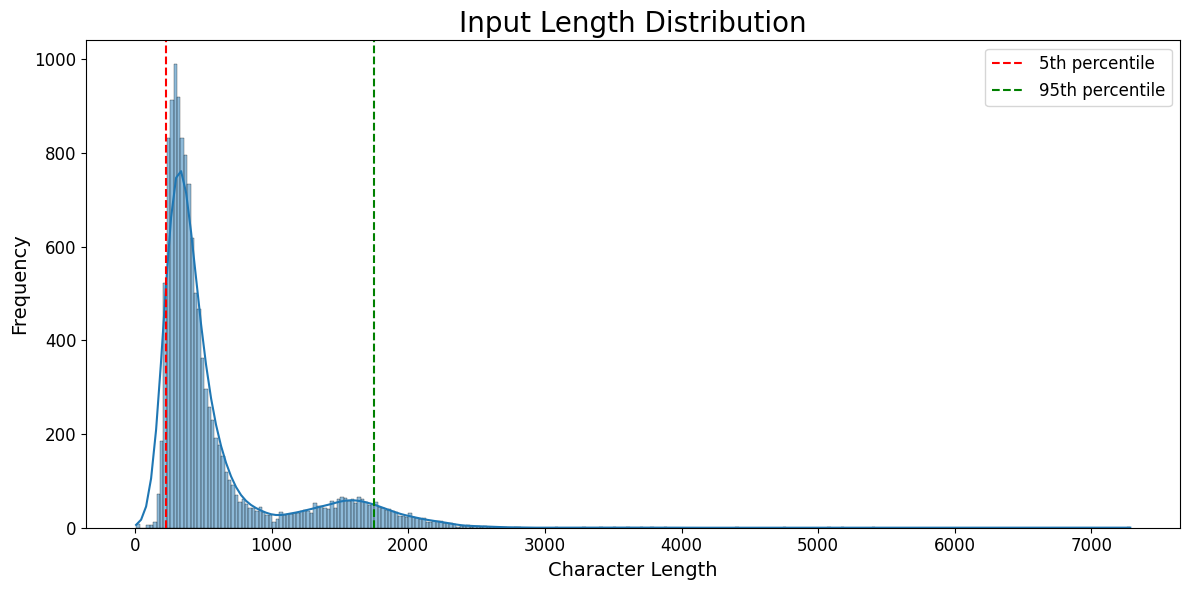

  • Output length distribution saved: cleaning_visualizations/output_length_distribution.png


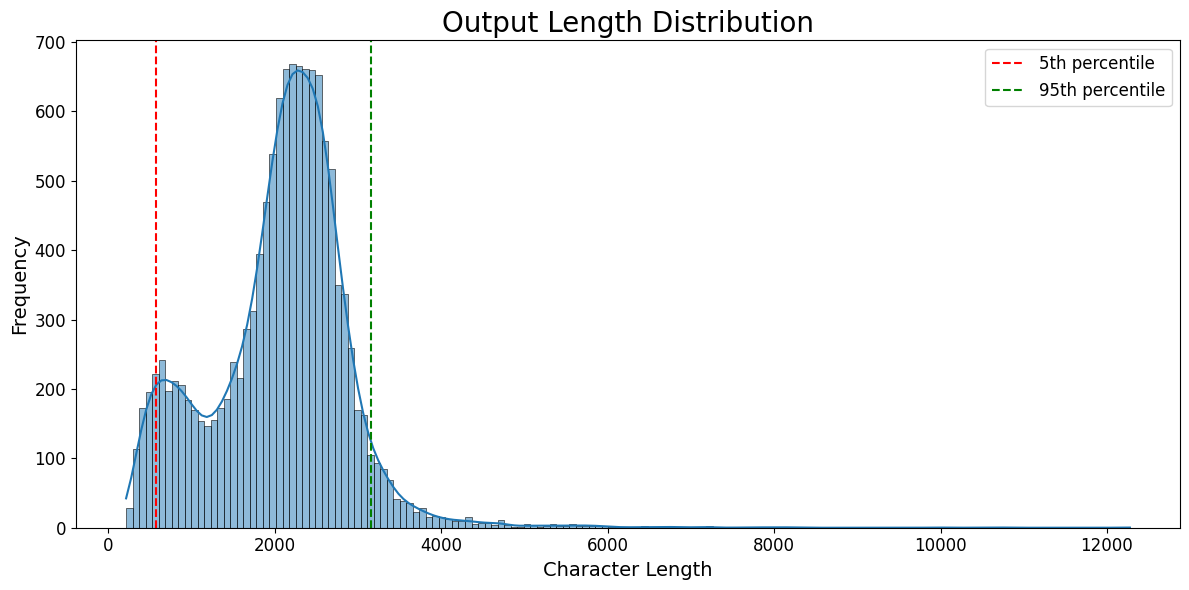

In [51]:
# Calculate Length Statistics and Visualize

log_section("Analysis Of Text Length")
log_step("Calculating text length statistics to treat potential outliers")

# Add length columns to training data
train_with_lens = train_df.with_columns([
    pl.col("instruction").str.len_chars().alias("instruction_len"),
    pl.col("input").str.len_chars().alias("input_len"),
    pl.col("output").str.len_chars().alias("output_len")
])

# Calculate statistics for each column (intorduction, input, output)
stats = {
    "instruction": {
        "min": train_with_lens["instruction_len"].min(),
        "max": train_with_lens["instruction_len"].max(),
        "mean": train_with_lens["instruction_len"].mean(),
        "median": train_with_lens["instruction_len"].median(),
        "p05": train_with_lens.select(pl.col("instruction_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("instruction_len").quantile(0.95)).item()
    },
    "input": {
        "min": train_with_lens["input_len"].min(),
        "max": train_with_lens["input_len"].max(),
        "mean": train_with_lens["input_len"].mean(),
        "median": train_with_lens["input_len"].median(),
        "p05": train_with_lens.select(pl.col("input_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("input_len").quantile(0.95)).item()
    },
    "output": {
        "min": train_with_lens["output_len"].min(),
        "max": train_with_lens["output_len"].max(),
        "mean": train_with_lens["output_len"].mean(),
        "median": train_with_lens["output_len"].median(),
        "p05": train_with_lens.select(pl.col("output_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("output_len").quantile(0.95)).item()
    }
}

# log stats for the length statistics
for field, field_stats in stats.items():
    log_step(f"{field.capitalize()} length statistics")
    for stat_name, value in field_stats.items():
        log_metric(stat_name, f"{value:.1f}" if isinstance(value, float) else f"{value:,}")

log_step("Generating length distribution visualizations")

# Visualize with histogram for further analysis (default values for consistency)
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Visualize each field in its own figure
for field in ["instruction", "input", "output"]:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_with_lens[f"{field}_len"], kde=True)
    plt.axvline(x=stats[field]["p05"], color='r', linestyle='--', label='5th percentile')
    plt.axvline(x=stats[field]["p95"], color='g', linestyle='--', label='95th percentile')
    plt.title(f"{field.capitalize()} Length Distribution", fontsize=20)
    plt.xlabel("Character Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.tight_layout()
    file_path = f"cleaning_visualizations/{field}_length_distribution.png"
    plt.savefig(file_path)
    log_metric(f"{field.capitalize()} length distribution saved", file_path)
    plt.show()

In [52]:
# Set Data Thresholds
log_section("Data Thresholds")
log_step("Setting data thresholds based on percentiles for outlier treatment")

# 5th percentile is minimum threshold
input_min_len = stats["input"]["p05"]
output_min_len = stats["output"]["p05"]

log_metric("Input minimum length threshold (5th percentile)", f"{input_min_len:.1f} characters")
log_metric("Output minimum length threshold (5th percentile)", f"{output_min_len:.1f} characters")

=============================== Data Thresholds ================================

--- Setting data thresholds based on percentiles for outlier treatment ---

  • Input minimum length threshold (5th percentile): 227.0 characters
  • Output minimum length threshold (5th percentile): 574.0 characters


In [53]:
# Define function to clean the data
log_section("Cleaning the dataset")

def clean_dataset(df, thresholds, split_name):
    log_step(f"Cleaning {split_name} split")

    original_size = df.shape[0]
    log_metric("Original size", f"{original_size:,} rows")

    # 1) Remove nulls
    step1_df = df.filter(~pl.col("input").is_null())
    nulls_removed = original_size - step1_df.shape[0]
    log_metric("Null values removed", f"{nulls_removed:,} ({nulls_removed/original_size*100:.2f}% of original)")

    # 2) Trim whitespace
    step2_df = step1_df.select([
        pl.col("instruction").str.strip_chars().alias("instruction"),
        pl.col("input").str.strip_chars().alias("input"),
        pl.col("output").str.strip_chars().alias("output")
    ])

    # 3) Remove duplicates
    step3_df = step2_df.unique()
    duplicates_removed = step2_df.shape[0] - step3_df.shape[0]
    log_metric("Duplicates removed", f"{duplicates_removed:,} ({duplicates_removed/step2_df.shape[0]*100:.2f}% of whitespace-trimmed)")

    # 4) Filter by length
    step4_df = step3_df.filter(
        (pl.col("input").str.len_chars() >= thresholds["input_min"]) &
        (pl.col("output").str.len_chars() >= thresholds["output_min"])
    )
    length_filtered = step3_df.shape[0] - step4_df.shape[0]
    log_metric("Short examples filtered", f"{length_filtered:,} ({length_filtered/step3_df.shape[0]*100:.2f}% of deduplicated)")

    # Final summary
    total_removed = original_size - step4_df.shape[0]
    log_metric("Total examples removed", f"{total_removed:,} ({total_removed/original_size*100:.2f}% of original)")
    log_metric("Final size", f"{step4_df.shape[0]:,} rows")

    return step4_df

# Apply cleaning to all splits with same thresholds to maintain consistency
thresholds = {"input_min": input_min_len, "output_min": output_min_len}
train_clean = clean_dataset(train_df, thresholds, "training")
val_clean = clean_dataset(val_df, thresholds, "validation")
test_clean = clean_dataset(test_df, thresholds, "test")

============================= Cleaning the dataset =============================

--- Cleaning training split ---

  • Original size: 12,867 rows
  • Null values removed: 22 (0.17% of original)
  • Duplicates removed: 53 (0.41% of whitespace-trimmed)
  • Short examples filtered: 1,175 (9.19% of deduplicated)
  • Total examples removed: 1,250 (9.71% of original)
  • Final size: 11,617 rows

--- Cleaning validation split ---

  • Original size: 1,608 rows
  • Null values removed: 3 (0.19% of original)
  • Duplicates removed: 0 (0.00% of whitespace-trimmed)
  • Short examples filtered: 156 (9.72% of deduplicated)
  • Total examples removed: 159 (9.89% of original)
  • Final size: 1,449 rows

--- Cleaning test split ---

  • Original size: 1,609 rows
  • Null values removed: 2 (0.12% of original)
  • Duplicates removed: 5 (0.31% of whitespace-trimmed)
  • Short examples filtered: 139 (8.68% of deduplicated)
  • Total examples removed: 146 (9.07% of original)
  • Final size: 1,463 rows


=========================== After Cleaning Analysis ============================

--- Generating length distribution visualizations after cleaning ---


--- Inputs and outputs below the 5th percentile were removed due to being too short to be meaningful—especially since our inputs simulate user speech ---


--- We retained examples above the 95th percentile, as longer inputs and responses may provide richer context.These can be revisited later if a token limit is required ---


)
  • Instruction cleaned length distribution saved: cleaning_visualizations/instruction_length_distribution_after_cleaning.png


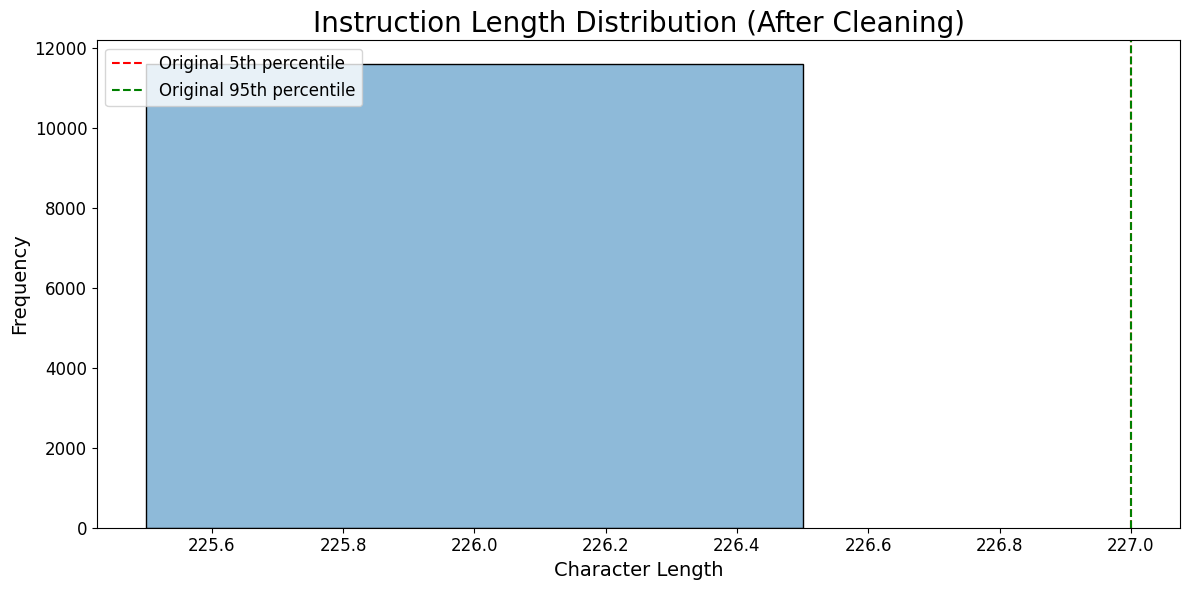

  • Input cleaned length distribution saved: cleaning_visualizations/input_length_distribution_after_cleaning.png


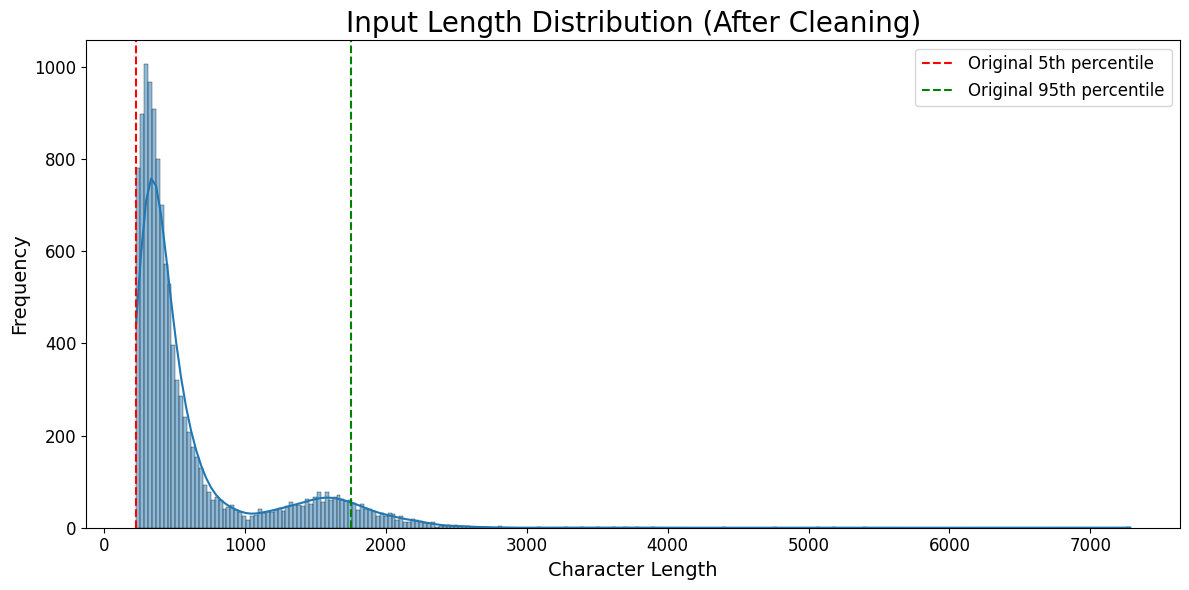

  • Output cleaned length distribution saved: cleaning_visualizations/output_length_distribution_after_cleaning.png


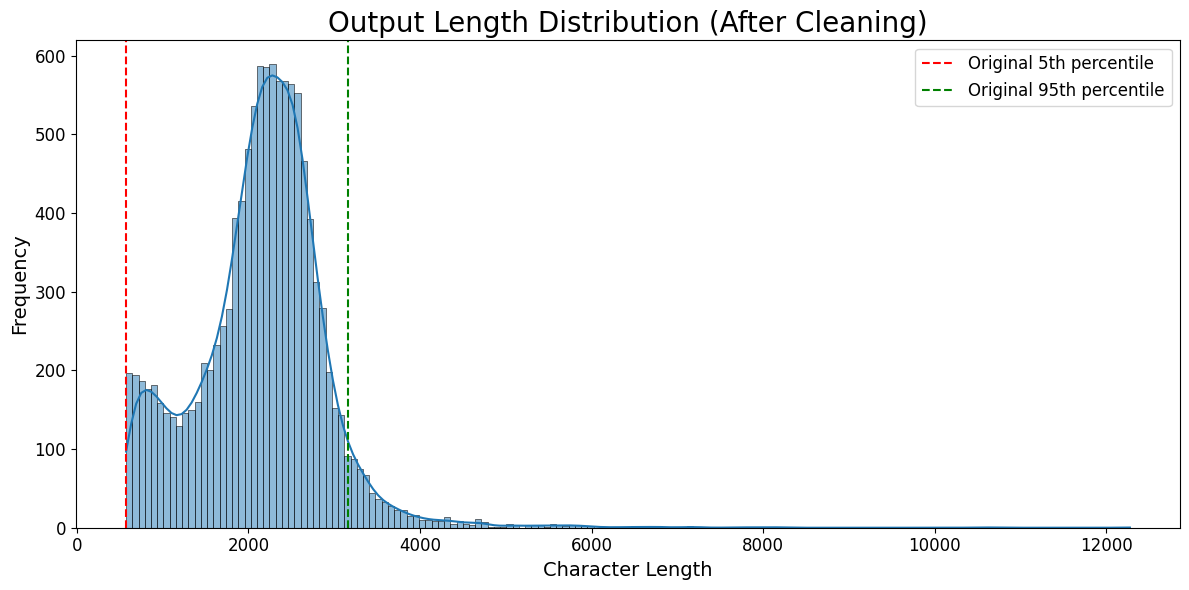

In [54]:
log_section("After Cleaning Analysis")

# Recalculate length columns on cleaned training set
train_clean_with_lens = train_clean.with_columns([
    pl.col("instruction").str.len_chars().alias("instruction_len"),
    pl.col("input").str.len_chars().alias("input_len"),
    pl.col("output").str.len_chars().alias("output_len")
])

# Optional: recalculate stats if needed for updated percentiles
# Or reuse existing ones if you want consistent reference lines
log_step("Generating length distribution visualizations after cleaning")
log_step("Inputs and outputs below the 5th percentile were removed due to being too short to be meaningful—especially since our inputs simulate user speech")
log_step("We retained examples above the 95th percentile, as longer inputs and responses may provide richer context.These can be revisited later if a token limit is required")

print("\n)")

# Reuse same style as the BEFORE graphs
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Generate and save new plots
for field in ["instruction", "input", "output"]:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_clean_with_lens[f"{field}_len"], kde=True)

    # (Optional) Add original percentiles from uncleaned data
    plt.axvline(x=stats[field]["p05"], color='r', linestyle='--', label='Original 5th percentile')
    plt.axvline(x=stats[field]["p95"], color='g', linestyle='--', label='Original 95th percentile')

    plt.title(f"{field.capitalize()} Length Distribution (After Cleaning)", fontsize=20)
    plt.xlabel("Character Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.tight_layout()

    file_path = f"cleaning_visualizations/{field}_length_distribution_after_cleaning.png"
    plt.savefig(file_path)
    log_metric(f"{field.capitalize()} cleaned length distribution saved", file_path)
    plt.show()

In [55]:
# Final Dataset Summary

log_section("Final Summary")
log_step("Dataset sizes after cleaning")
log_comparison("Training set", train_df.shape[0], train_clean.shape[0])
log_comparison("Validation set", val_df.shape[0], val_clean.shape[0])
log_comparison("Test set", test_df.shape[0], test_clean.shape[0])
log_comparison("Total dataset", all_data.shape[0], train_clean.shape[0] + val_clean.shape[0] + test_clean.shape[0])

================================ Final Summary =================================

--- Dataset sizes after cleaning ---

  • Training set: 12,867 → 11,617 rows (1,250 removed, 9.71% reduction)
  • Validation set: 1,608 → 1,449 rows (159 removed, 9.89% reduction)
  • Test set: 1,609 → 1,463 rows (146 removed, 9.07% reduction)
  • Total dataset: 16,084 → 14,529 rows (1,555 removed, 9.67% reduction)


In [56]:
# Save Cleaned Datasets

log_section("Saving Cleaned Datasets")
log_step("Saving the cleaned datasets for future use")
# Convert back to Hugging Face dataset format if needed
# Or save as Parquet/CSV files
train_clean.write_parquet("cleaned_train.parquet")
val_clean.write_parquet("cleaned_val.parquet")
# Convert back to Hugging Face dataset format if needed
# save as parquet for now
train_clean.write_parquet("cleaned_train.parquet")
val_clean.write_parquet("cleaned_val.parquet")
test_clean.write_parquet("cleaned_test.parquet")

log_metric("Training set saved", "cleaned_train.parquet")
log_metric("Validation set saved", "cleaned_val.parquet")
log_metric("Test set saved", "cleaned_test.parquet")
print("\n")
log_section("Cleaning complete.")
log_step("The data has been cleaned, split, and images have been saved.")


=========================== Saving Cleaned Datasets ============================

--- Saving the cleaned datasets for future use ---

  • Training set saved: cleaned_train.parquet
  • Validation set saved: cleaned_val.parquet
  • Test set saved: cleaned_test.parquet


============================== Cleaning complete. ==============================

--- The data has been cleaned, split, and images have been saved. ---



## TRAINING

In [57]:
log_section("Adding Metadata (Emotion Tags)")
log_step("Associating emotion tags with dataset entries")

======================== Adding Metadata (Emotion Tags) ========================

--- Associating emotion tags with dataset entries ---



In [58]:
def add_metadata_to_datasets(train_clean, val_clean, test_clean):
    log_section("Adding Metadata")
    log_step("Adding emotion and severity metadata to datasets")

    # Define emotion categories and severity levels
    emotions = ["anxiety", "sadness", "frustration", "hope", "neutral", "fear", "gratitude"]
    severity_levels = ["low", "medium", "high"]

    # Simple rule-based emotion and severity detection
    def detect_emotion_and_severity(text):
        if text is None:
            return "neutral", "low"

        text = text.lower()

        # Simple keyword matching for emotions
        emotion_keywords = {
            "anxiety": ["anxious", "worry", "nervous", "panic", "stress", "tense", "uneasy"],
            "sadness": ["sad", "depressed", "unhappy", "miserable", "down", "blue", "grief"],
            "frustration": ["frustrated", "annoyed", "irritated", "angry", "upset", "mad"],
            "hope": ["hope", "optimistic", "better", "improve", "progress", "positive"],
            "fear": ["afraid", "scared", "terrified", "fear", "dread", "frightened"],
            "gratitude": ["thank", "grateful", "appreciate", "thankful", "blessed"],
            "neutral": []  # Default
        }

        # Count keyword matches for each emotion
        emotion_scores = {emotion: 0 for emotion in emotions}
        for emotion, keywords in emotion_keywords.items():
            for keyword in keywords:
                if keyword in text:
                    emotion_scores[emotion] += 1

        # Determine dominant emotion
        dominant_emotion = max(emotion_scores.items(), key=lambda x: x[1])[0]
        if emotion_scores[dominant_emotion] == 0:
            dominant_emotion = "neutral"

        # Simple heuristic for severity
        severity_indicators = {
            "high": ["very", "extremely", "severe", "terrible", "worst", "unbearable", "always", "constantly"],
            "medium": ["quite", "moderately", "somewhat", "often", "frequently", "regularly"],
            "low": ["slightly", "mild", "occasionally", "sometimes", "a bit", "a little", "rarely"]
        }

        # Count severity indicators
        severity_scores = {level: 0 for level in severity_levels}
        for level, indicators in severity_indicators.items():
            for indicator in indicators:
                if indicator in text:
                    severity_scores[level] += 1

        # Determine severity level
        if severity_scores["high"] > 0:
            severity = "high"
        elif severity_scores["medium"] > 0:
            severity = "medium"
        else:
            severity = "low"

        return dominant_emotion, severity

    # Function to add metadata to a dataset
    def add_metadata_to_dataset(df, name):
        log_step(f"Adding metadata to {name} dataset")

        # Convert to pandas for easier manipulation
        pdf = df.to_pandas()

        # Add emotion and severity columns
        emotions = []
        severities = []

        for _, row in pdf.iterrows():
            emotion, severity = detect_emotion_and_severity(row["input"])
            emotions.append(emotion)
            severities.append(severity)

        # Add as new columns
        pdf["emotion"] = emotions
        pdf["severity"] = severities

        # Convert back to polars
        result_df = pl.from_pandas(pdf)

        # Log statistics
        emotion_counts = pdf["emotion"].value_counts()
        severity_counts = pdf["severity"].value_counts()

        log_metric(f"{name} dataset emotion distribution", emotion_counts.to_dict())
        log_metric(f"{name} dataset severity distribution", severity_counts.to_dict())

        return result_df

    # Add metadata to each dataset
    train_with_metadata = add_metadata_to_dataset(train_clean, "Training")
    val_with_metadata = add_metadata_to_dataset(val_clean, "Validation")
    test_with_metadata = add_metadata_to_dataset(test_clean, "Test")

    # Visualize metadata distribution
    log_step("Generating metadata distribution visualizations")

    # Convert to pandas for visualization
    train_pdf = train_with_metadata.to_pandas()

    # Emotion distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_pdf, x="emotion")
    plt.title("Emotion Distribution in Training Data")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("cleaning_visualizations/emotion_distribution.png")
    log_metric("Visualization saved", "cleaning_visualizations/emotion_distribution.png")

    # Severity distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_pdf, x="severity")
    plt.title("Severity Distribution in Training Data")
    plt.xlabel("Severity Level")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("cleaning_visualizations/severity_distribution.png")
    log_metric("Visualization saved", "cleaning_visualizations/severity_distribution.png")

    # Save datasets with metadata
    train_with_metadata.write_parquet("train_with_metadata.parquet")
    val_with_metadata.write_parquet("val_with_metadata.parquet")
    test_with_metadata.write_parquet("test_with_metadata.parquet")

    log_metric("Datasets with metadata saved", "train_with_metadata.parquet, val_with_metadata.parquet, test_with_metadata.parquet")

    return train_with_metadata, val_with_metadata, test_with_metadata

In [59]:
#### MIGHT CHANGE FOR RAG #####

In [60]:
def generate_enhanced_prompts(train_with_metadata):
    log_section("Prompt Engineering")
    log_step("Generating enhanced prompts based on prompt engineering guidelines")
    os.makedirs("sonar_prompts", exist_ok=True)


    # Base system message that establishes role, communication style, and boundaries
    base_system_message = """You are a supportive and empathetic AI companion designed to listen to users, offer helpful reflections, and encourage positive coping mechanisms for voice-related concerns. You are not a medical professional and cannot provide diagnoses or treatment advice.

Respond in an encouraging, understanding, and non-judgmental tone. Use active listening techniques such as paraphrasing and summarizing to show you're engaged. Keep responses concise and focused on the user's immediate concerns.

Guidelines for your responses:
- Use emotionally sensitive language that acknowledges the user's feelings
- Maintain cultural neutrality in your suggestions and reflections
- Ask open-ended questions to encourage user reflection
- Focus on active listening rather than immediate solutions
- Avoid clinical terminology that might create unrealistic expectations
- Encourage users to seek professional help when appropriate"""

    # Define emotion-specific system message additions
    emotion_prompts = {
        "anxiety": "The user appears to be experiencing anxiety. Acknowledge their feelings of worry or nervousness. Offer simple breathing techniques that can help relax vocal tension. Use a calm, reassuring tone and avoid overwhelming them with too many suggestions at once.",

        "sadness": "The user appears to be experiencing sadness. Validate their feelings without trying to immediately cheer them up. Suggest gentle vocal exercises that can help express emotions. Use a warm, supportive tone and acknowledge that voice work during emotional periods can be challenging.",

        "frustration": "The user appears to be experiencing frustration. Acknowledge their feelings without dismissing them. Suggest focused, structured voice techniques that provide a sense of control. Use a clear, direct tone while maintaining empathy.",

        "hope": "The user appears to be feeling hopeful. Build on this positive emotion by reinforcing their optimism. Suggest progressive voice exercises that can help them track improvement. Use an encouraging tone that matches their positive outlook.",

        "fear": "The user appears to be experiencing fear. Provide reassurance and grounding techniques. Suggest simple voice exercises that can be done in the moment to help manage anxiety. Use a calm, steady tone and avoid overwhelming them with complex information.",

        "gratitude": "The user appears to be expressing gratitude. Acknowledge their positive sentiment and use it as an opportunity to reinforce their progress. Suggest ways to build on their current success. Use a warm, appreciative tone that matches their sentiment.",

        "neutral": "The user's emotional state appears neutral. Provide balanced, informative responses. Suggest evidence-based voice therapy techniques tailored to their specific concerns. Use a professional, supportive tone."
    }

    # Define severity-specific modifications
    severity_modifications = {
        "low": "The user's concerns appear to be mild. Focus on preventative techniques and maintenance exercises. Keep explanations brief and practical, emphasizing daily habits that can maintain vocal health.",

        "medium": "The user's concerns appear to be moderate. Provide a balance of immediate relief techniques and longer-term exercises. Include moderate detail in explanations, focusing on consistent practice and gradual improvement.",

        "high": "The user's concerns appear to be severe. Prioritize immediate relief strategies first, followed by structured intervention plans. Provide detailed, step-by-step guidance with frequent check-ins. Strongly encourage professional consultation while being supportive."
    }


    # Template for including conversation history
    conversation_history_template = """
Previous conversation:
{conversation_history}

Current user message:
{current_message}"""

    # Template for including summarized conversation
    conversation_summary_template = """
Conversation summary:
{conversation_summary}

Recent exchanges:
{recent_exchanges}

Current user message:
{current_message}"""

    # Template for including relevant past interactions
    relevant_memory_template = """
Relevant past information:
{relevant_memories}

Current user message:
{current_message}"""

    # Generate combined prompts for each emotion-severity combination
    combined_prompts = {}

    for emotion, emotion_prompt in emotion_prompts.items():
        for severity, severity_prompt in severity_modifications.items():
            key = f"{emotion}_{severity}"

            # Combine base system message with emotion and severity specific guidance
            combined_prompts[key] = {
                "system_message": f"{base_system_message}\n\n{emotion_prompt}\n\n{severity_prompt}",
                "conversation_history_template": conversation_history_template,
                "conversation_summary_template": conversation_summary_template,
                "relevant_memory_template": relevant_memory_template
            }

    # Save prompts to file
    with open("sonar_prompts/enhanced_prompts.json", "w") as f:
        json.dump(combined_prompts, f, indent=2)

    log_metric("Enhanced prompts generated", len(combined_prompts))
    log_metric("Prompts saved to", "sonar_prompts/enhanced_prompts.json")

    # Generate example few-shot learning prompts
    log_step("Generating few-shot learning examples")

    # Convert to pandas for easier filtering
    train_pdf = train_with_metadata.to_pandas()

    few_shot_examples = {}

    # For each emotion-severity combination, find a good example
    for emotion in emotion_prompts.keys():
        for severity in severity_modifications.keys():
            key = f"{emotion}_{severity}"

            # Filter dataset
            filtered = train_pdf[(train_pdf["emotion"] == emotion) & (train_pdf["severity"] == severity)]

            if len(filtered) > 0:
                # Take the first example (or you could implement better selection logic)
                example = filtered.iloc[0]

                few_shot_examples[key] = {
                    "input": example["input"],
                    "output": example["output"]
                }
            else:
                few_shot_examples[key] = {
                    "input": "No example available for this combination",
                    "output": "No example available for this combination"
                }

    # Save few-shot examples to file
    with open("sonar_prompts/few_shot_examples.json", "w") as f:
        json.dump(few_shot_examples, f, indent=2)

    log_metric("Few-shot examples generated", len(few_shot_examples))
    log_metric("Examples saved to", "sonar_prompts/few_shot_examples.json")

    return {
        "system_prompts": combined_prompts,
        "few_shot_examples": few_shot_examples
    }

In [61]:
def prepare_data_for_sonar(train_with_metadata, val_with_metadata, test_with_metadata):
    log_section("Preparing data for Sonar API")
    log_step("Formatting data for Sonar API")

    # Create output directory for sonar data
    os.makedirs("sonar_data", exist_ok=True)

    # Function to convert a dataset to the Sonar API format
    def format_dataset_for_sonar(df, name):
        log_step(f"Formatting {name} dataset")

        formatted_data = []
        df_pandas = df.to_pandas()
        for _, row in df_pandas.iterrows():
            # Format as a conversation with system, user, and assistant messages
            example = {
                "input": row["input"],
                "expected_output": row["output"],
                "emotion": row["emotion"],
                "severity": row["severity"]
            }

            formatted_data.append(example)

        # Save as JSON file
        output_file = f"sonar_data/{name.lower()}_data.json"
        with open(output_file, "w") as f:
            json.dump(formatted_data, f, indent=2)

        log_metric(f"{name} dataset formatted and saved", output_file)
        log_metric(f"Number of examples", len(formatted_data))

        return formatted_data

    # Format each dataset
    train_formatted = format_dataset_for_sonar(train_with_metadata, "Train")
    val_formatted = format_dataset_for_sonar(val_with_metadata, "Val")
    test_formatted = format_dataset_for_sonar(test_with_metadata, "Test")

    log_step("Data preparation for Sonar API completed")

    return train_formatted, val_formatted, test_formatted

In [62]:
#setup sonar api

def setup_sonar_api():
    log_section("Sonar API setup")

    SONAR_API_KEY = my_api_key

    # Test API connection
    headers = {
        "Authorization": f"Bearer {SONAR_API_KEY}",
        "Content-Type": "application/json"
    }

    log_metric("API key configured", "✓")
    log_metric("Headers prepared", "✓")

    return {
        "api_key": SONAR_API_KEY,
        "headers": headers,
        "base_url": "https://api.perplexity.ai"
    }

# EVALUATION

In [63]:
import nltk
print("Punkt found at:", nltk.data.find("tokenizers/punkt"))
print("Punkt_tab   at:", nltk.data.find("tokenizers/punkt_tab"))


Punkt found at: /content/nltk_data/tokenizers/punkt
Punkt_tab   at: /content/nltk_data/tokenizers/punkt_tab


In [64]:
# --- New Function for BERTScore Calculation ---
def calculate_bert_score(reference: str, candidate: str, scorer: BERTScorer) -> dict:
    """
    Calculate BERTScore between reference and candidate texts.

    Args:
        reference: Reference text (expected output)
        candidate: Candidate text (model output)
        scorer: An initialized BERTScorer object.

    Returns:
        dict: BERTScore precision, recall, and F1.
    """
    if not reference.strip() or not candidate.strip():
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0
        }
    try:
        # BERTScore expects lists of strings
        P, R, F1 = scorer.score([candidate], [reference])
        return {
            "precision": P.mean().item(),
            "recall": R.mean().item(),
            "f1": F1.mean().item()
        }
    except Exception as e:
        print(f"[BERTScore] Error calculating BERTScore: {str(e)}")
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0
        }

# --- Existing BLEU and ROUGE Functions (Keep as is, or remove BLEU if no longer needed) ---

def calculate_bleu_score(reference, candidate):
    """
    Calculate BLEU score between reference and candidate texts.

    Args:
        reference: Reference text (expected output)
        candidate: Candidate text (model output)

    Returns:
        dict: BLEU scores at different n-gram levels
    """
    # Tokenize texts
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())

    # Handle empty sequences
    if not reference_tokens or not candidate_tokens:
        return {
            "bleu-1": 0.0,
            "bleu-2": 0.0,
            "bleu-3": 0.0,
            "bleu-4": 0.0,
            "bleu-avg": 0.0
        }

    # Use smoothing to avoid zero scores when there are no n-gram overlaps
    smoothie = SmoothingFunction().method1

    # Calculate BLEU scores for different n-gram levels
    bleu1 = sentence_bleu([reference_tokens], candidate_tokens,
                         weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu([reference_tokens], candidate_tokens,
                         weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu([reference_tokens], candidate_tokens,
                         weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu([reference_tokens], candidate_tokens,
                         weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    # Calculate average BLEU score
    bleu_avg = (bleu1 + bleu2 + bleu3 + bleu4) / 4

    return {
        "bleu-1": bleu1,
        "bleu-2": bleu2,
        "bleu-3": bleu3,
        "bleu-4": bleu4,
        "bleu-avg": bleu_avg
    }

def calculate_rouge_scores(reference: str, candidate: str) -> dict:
    """
    Compute ROUGE-1, ROUGE-2 and ROUGE-L scores (precision, recall, F-measure)
    and return them with keys: precision, recall, f1.

    Returns
    -------
    dict
        {
          "rouge-1": {"precision": .., "recall": .., "f1": ..},
          "rouge-2": {"precision": .., "recall": .., "f1": ..},
          "rouge-l": {"precision": .., "recall": .., "f1": ..}
        }
    """
    rouge = Rouge()

    # Guard against blank strings
    if not reference.strip() or not candidate.strip():
        zero = {"precision": 0.0, "recall": 0.0, "f1": 0.0}
        return {"rouge-1": zero, "rouge-2": zero, "rouge-l": zero}

    try:
        raw = rouge.get_scores(candidate, reference)[0]   # keys: 'rouge-1'→{'p','r','f'}, etc.

        def rename(metric_dict):
            return {
                "precision": metric_dict["p"],
                "recall":    metric_dict["r"],
                "f1":        metric_dict["f"],
            }

        return {
            "rouge-1": rename(raw["rouge-1"]),
            "rouge-2": rename(raw["rouge-2"]),
            "rouge-l": rename(raw["rouge-l"]),
        }

    except Exception as e:
        print(f"[ROUGE] Error: {e}")
        zero = {"precision": 0.0, "recall": 0.0, "f1": 0.0}
        return {"rouge-1": zero, "rouge-2": zero, "f1": 0.0}


# --- Modified evaluate_prompt_strategies_with_bleu_rouge function ---
def evaluate_prompt_strategies_with_bleu_rouge_and_bertscore(api_config, test_data, prompts, model="sonar"):
    """
    Evaluate different prompt strategies using the Sonar API with BLEU, ROUGE, and BERTScore metrics.

    Args:
        api_config: API configuration
        test_data: Test data examples
        prompts: Optimized prompts
        model: Model name to use

    Returns:
        dict: Evaluation results for each strategy
    """
    print(f"\n{'=' * 80}")
    print(f"EVALUATING PROMPT STRATEGIES WITH BLEU, ROUGE, AND BERTSCORE - MODEL: {model}".center(80))
    print(f"{'=' * 80}\n")

    # Define prompt strategies to test (unchanged)
    strategies = {
        "base": {
            "name": "Base Prompt",
            "description": "Simple system message without emotion or severity tailoring",
            "system_message": "You are a helpful voice therapy assistant. Provide supportive, empathetic responses to users seeking help with voice-related concerns."
        },
        "emotion_only": {
            "name": "Emotion-Tailored",
            "description": "System message tailored to detected emotion",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_medium"]["system_message"]
        },
        "severity_only": {
            "name": "Severity-Tailored",
            "description": "System message tailored to detected severity",
            "get_system_message": lambda example: prompts["system_prompts"][f"neutral_{example['severity']}"]["system_message"]
        },
        "emotion_severity": {
            "name": "Fully Tailored",
            "description": "System message tailored to both emotion and severity",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_{example['severity']}"]["system_message"]
        },
        "few_shot": {
            "name": "Few-Shot Learning",
            "description": "Includes a relevant example before the user query",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_{example['severity']}"]["system_message"],
            "include_few_shot": True
        }
    }

    # Initialize BERTScorer once
    # You can choose a different BERT model (e.g., 'bert-base-uncased', 'roberta-large')
    # Use 'device' for GPU if available, e.g., device='cuda:0' or 'cpu'
    print("Initializing BERTScorer... This may take a moment.")
    scorer = BERTScorer(lang="en", rescale_with_baseline=True, device="cuda" if torch.cuda.is_available() else "cpu")
    print("BERTScorer initialized.")


    # Process a subset of examples to avoid excessive API calls
    sample_size = min(40, len(test_data))
    print(f"  • Evaluating sample size: {sample_size}")
    test_sample = test_data[:sample_size]

    # Results storage
    all_results = {}

    # Create output directory
    os.makedirs("sonar_evaluation", exist_ok=True)

    # Evaluate each strategy
    for strategy_key, strategy in strategies.items():
        print(f"\n--- Testing strategy: {strategy['name']} ---\n")

        results = []

        for i, example in enumerate(tqdm(test_sample)):
            # Extract data
            user_input = example["input"]
            expected_output = example["expected_output"]
            emotion = example["emotion"]
            severity = example["severity"]

            # Get system message based on strategy
            if "get_system_message" in strategy:
                system_message = strategy["get_system_message"](example)
            else:
                system_message = strategy["system_message"]

            # Prepare messages
            messages = [
                {
                    "role": "system",
                    "content": system_message
                }
            ]

            # Add few-shot example if strategy includes it
            if strategy.get("include_few_shot", False):
                few_shot_key = f"{emotion}_{severity}"
                if few_shot_key in prompts["few_shot_examples"]:
                    few_shot = prompts["few_shot_examples"][few_shot_key]
                    if few_shot["input"] != "No example available for this combination":
                        messages.append({
                            "role": "user",
                            "content": few_shot["input"]
                        })
                        messages.append({
                            "role": "assistant",
                            "content": few_shot["output"]
                        })

            # Add user input
            messages.append({
                "role": "user",
                "content": user_input
            })

            # Prepare request
            url = f"{api_config['base_url']}/chat/completions"
            payload = {
                "model": model,
                "messages": messages
            }

            try:
                # Make API call
                response = requests.post(url, headers=api_config["headers"], json=payload)

                if response.status_code == 200:
                    response_data = response.json()
                    model_output = response_data["choices"][0]["message"]["content"]

                    # Calculate length metrics
                    output_length = len(model_output)
                    expected_length = len(expected_output)
                    length_ratio = min(output_length, expected_length) / max(output_length, expected_length)

                    # Calculate BLEU scores
                    bleu_scores = calculate_bleu_score(expected_output, model_output)

                    # Calculate ROUGE scores
                    rouge_scores = calculate_rouge_scores(expected_output, model_output)

                    # Calculate BERTScore
                    bert_scores = calculate_bert_score(expected_output, model_output, scorer)

                    # Store result
                    result = {
                        "id": i,
                        "input": user_input,
                        "expected_output": expected_output,
                        "model_output": model_output,
                        "emotion": emotion,
                        "severity": severity,
                        "metrics": {
                            "output_length": output_length,
                            "expected_length": expected_length,
                            "length_ratio": length_ratio,
                            "bleu": bleu_scores,
                            "rouge": rouge_scores,
                            "bertscore": bert_scores # Add BERTScore here
                        }
                    }

                    results.append(result)

                    print(f"  • Example {i} processed: ✓")
                    print(f"    - BLEU-Avg: {bleu_scores['bleu-avg']:.4f}")
                    print(f"    - ROUGE-L F1: {rouge_scores['rouge-l']['f1']:.4f}")
                    print(f"    - BERTScore F1: {bert_scores['f1']:.4f}") # Print BERTScore
                else:
                    print(f"  • Example {i} failed: Status code: {response.status_code}")

                # Add a small delay to avoid rate limiting
                time.sleep(0.5)

            except Exception as e:
                print(f"  • Example {i} error: {str(e)}")

        # Save strategy results
        all_results[strategy_key] = results

        # Save to file
        with open(f"sonar_evaluation/{strategy_key}_results_with_all_metrics.json", "w") as f: # Renamed file for clarity
            json.dump(results, f, indent=2)

        print(f"  • Strategy results saved: sonar_evaluation/{strategy_key}_results_with_all_metrics.json")

    # Analyze and compare strategies
    analyze_strategy_results_with_all_metrics(all_results, strategies) # Call the new analysis function

    return all_results


# --- Modified analyze_strategy_results_with_bleu_rouge function to include BERTScore ---
def analyze_strategy_results_with_all_metrics(all_results, strategies):
    """
    Analyze and compare the results of different prompt strategies with BLEU, ROUGE, and BERTScore metrics.

    Args:
        all_results: Results from evaluate_prompt_strategies_with_bleu_rouge_and_bertscore
        strategies: Strategy definitions

    Returns:
        str: Best strategy key
    """
    print(f"\n{'=' * 80}")
    print("ANALYZING PROMPT STRATEGY RESULTS WITH BLEU, ROUGE, AND BERTSCORE".center(80))
    print(f"{'=' * 80}\n")

    # Calculate aggregate metrics for each strategy
    strategy_metrics = {}

    for strategy_key, results in all_results.items():
        strategy_name = strategies[strategy_key]["name"]

        # Skip if no results
        if not results:
            continue

        # Calculate average metrics
        avg_length_ratio = np.mean([r["metrics"]["length_ratio"] for r in results])
        avg_bleu_1 = np.mean([r["metrics"]["bleu"]["bleu-1"] for r in results])
        avg_bleu_2 = np.mean([r["metrics"]["bleu"]["bleu-2"] for r in results])
        avg_bleu_3 = np.mean([r["metrics"]["bleu"]["bleu-3"] for r in results])
        avg_bleu_4 = np.mean([r["metrics"]["bleu"]["bleu-4"] for r in results])
        avg_bleu_avg = np.mean([r["metrics"]["bleu"]["bleu-avg"] for r in results])

        avg_rouge_1_precision = np.mean([r["metrics"]["rouge"]["rouge-1"]["precision"] for r in results])
        avg_rouge_1_recall = np.mean([r["metrics"]["rouge"]["rouge-1"]["recall"] for r in results])
        avg_rouge_1_f1 = np.mean([r["metrics"]["rouge"]["rouge-1"]["f1"] for r in results])

        avg_rouge_2_precision = np.mean([r["metrics"]["rouge"]["rouge-2"]["precision"] for r in results])
        avg_rouge_2_recall = np.mean([r["metrics"]["rouge"]["rouge-2"]["recall"] for r in results])
        avg_rouge_2_f1 = np.mean([r["metrics"]["rouge"]["rouge-2"]["f1"] for r in results])

        avg_rouge_l_precision = np.mean([r["metrics"]["rouge"]["rouge-l"]["precision"] for r in results])
        avg_rouge_l_recall = np.mean([r["metrics"]["rouge"]["rouge-l"]["recall"] for r in results])
        avg_rouge_l_f1 = np.mean([r["metrics"]["rouge"]["rouge-l"]["f1"] for r in results])

        # BERTScore metrics
        avg_bert_precision = np.mean([r["metrics"]["bertscore"]["precision"] for r in results])
        avg_bert_recall = np.mean([r["metrics"]["bertscore"]["recall"] for r in results])
        avg_bert_f1 = np.mean([r["metrics"]["bertscore"]["f1"] for r in results])


        # Calculate metrics by emotion
        emotion_metrics = {}
        for emotion in ["anxiety", "sadness", "frustration", "hope", "neutral", "fear", "gratitude"]:
            emotion_results = [r for r in results if r["emotion"] == emotion]
            if emotion_results:
                emotion_metrics[emotion] = {
                    "count": len(emotion_results),
                    "avg_length_ratio": np.mean([r["metrics"]["length_ratio"] for r in emotion_results]),
                    "avg_bleu_avg": np.mean([r["metrics"]["bleu"]["bleu-avg"] for r in emotion_results]),
                    "avg_rouge_l_f1": np.mean([r["metrics"]["rouge"]["rouge-l"]["f1"] for r in emotion_results]),
                    "avg_bert_f1": np.mean([r["metrics"]["bertscore"]["f1"] for r in emotion_results]) # Add BERTScore
                }

        # Calculate metrics by severity
        severity_metrics = {}
        for severity in ["low", "medium", "high"]:
            severity_results = [r for r in results if r["severity"] == severity]
            if severity_results:
                severity_metrics[severity] = {
                    "count": len(severity_results),
                    "avg_length_ratio": np.mean([r["metrics"]["length_ratio"] for r in severity_results]),
                    "avg_bleu_avg": np.mean([r["metrics"]["bleu"]["bleu-avg"] for r in severity_results]),
                    "avg_rouge_l_f1": np.mean([r["metrics"]["rouge"]["rouge-l"]["f1"] for r in severity_results]),
                    "avg_bert_f1": np.mean([r["metrics"]["bertscore"]["f1"] for r in severity_results]) # Add BERTScore
                }

        # Store metrics
        strategy_metrics[strategy_key] = {
            "name": strategy_name,
            "sample_size": len(results),
            "avg_length_ratio": avg_length_ratio,
            "bleu": {
                "bleu-1": avg_bleu_1,
                "bleu-2": avg_bleu_2,
                "bleu-3": avg_bleu_3,
                "bleu-4": avg_bleu_4,
                "bleu-avg": avg_bleu_avg
            },
            "rouge": {
                "rouge-1": {
                    "precision": avg_rouge_1_precision,
                    "recall": avg_rouge_1_recall,
                    "f1": avg_rouge_1_f1
                },
                "rouge-2": {
                    "precision": avg_rouge_2_precision,
                    "recall": avg_rouge_2_recall,
                    "f1": avg_rouge_2_f1
                },
                "rouge-l": {
                    "precision": avg_rouge_l_precision,
                    "recall": avg_rouge_l_recall,
                    "f1": avg_rouge_l_f1
                }
            },
            "bertscore": { # Add BERTScore here
                "precision": avg_bert_precision,
                "recall": avg_bert_recall,
                "f1": avg_bert_f1
            },
            "emotion_metrics": emotion_metrics,
            "severity_metrics": severity_metrics
        }

    # Save metrics to file
    with open("sonar_evaluation/strategy_metrics_with_all_metrics.json", "w") as f: # Renamed file for clarity
        json.dump(strategy_metrics, f, indent=2)

    print(f"  • Strategy metrics saved: sonar_evaluation/strategy_metrics_with_all_metrics.json")

    # Create comparison visualizations
    print("\n--- Generating strategy comparison visualizations ---\n")

    # Create output directory for visualizations
    os.makedirs("sonar_evaluation/visualizations", exist_ok=True)

    # Prepare data for visualizations
    strategies_list = list(strategy_metrics.keys())
    strategy_names = [strategy_metrics[s]["name"] for s in strategies_list]

    # Length ratio comparison
    length_ratios = [strategy_metrics[s]["avg_length_ratio"] for s in strategies_list]

    # BLEU score comparison
    bleu_avg_scores = [strategy_metrics[s]["bleu"]["bleu-avg"] for s in strategies_list]
    bleu_1_scores = [strategy_metrics[s]["bleu"]["bleu-1"] for s in strategies_list]
    bleu_2_scores = [strategy_metrics[s]["bleu"]["bleu-2"] for s in strategies_list]
    bleu_3_scores = [strategy_metrics[s]["bleu"]["bleu-3"] for s in strategies_list]
    bleu_4_scores = [strategy_metrics[s]["bleu"]["bleu-4"] for s in strategies_list]

    # ROUGE score comparison
    rouge_1_f1_scores = [strategy_metrics[s]["rouge"]["rouge-1"]["f1"] for s in strategies_list]
    rouge_2_f1_scores = [strategy_metrics[s]["rouge"]["rouge-2"]["f1"] for s in strategies_list]
    rouge_l_f1_scores = [strategy_metrics[s]["rouge"]["rouge-l"]["f1"] for s in strategies_list]

    # BERTScore F1 comparison
    bert_f1_scores = [strategy_metrics[s]["bertscore"]["f1"] for s in strategies_list] # New line for BERTScore

    # Create comparison table
    comparison_data = {
        "Strategy": strategy_names,
        "Length Ratio": length_ratios,
        "BLEU-1": bleu_1_scores,
        "BLEU-2": bleu_2_scores,
        "BLEU-3": bleu_3_scores,
        "BLEU-4": bleu_4_scores,
        "BLEU-Avg": bleu_avg_scores,
        "ROUGE-1 F1": rouge_1_f1_scores,
        "ROUGE-2 F1": rouge_2_f1_scores,
        "ROUGE-L F1": rouge_l_f1_scores,
        "BERTScore F1": bert_f1_scores # Add BERTScore to table
    }

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv("sonar_evaluation/strategy_comparison_table_all_metrics.csv", index=False) # Renamed table

    # 1. Overall Length Ratio Comparison (unchanged)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=strategy_names, y=length_ratios)
    plt.title("Prompt Strategy Comparison - Average Length Ratio")
    plt.xlabel("Strategy")
    plt.ylabel("Avg Length Ratio (higher is better)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("sonar_evaluation/visualizations/length_ratio_comparison.png")

    # 2. BLEU Score Comparison (unchanged)
    plt.figure(figsize=(14, 8))

    x = np.arange(len(strategy_names))
    width = 0.15

    plt.bar(x - 2*width, bleu_1_scores, width, label='BLEU-1')
    plt.bar(x - width, bleu_2_scores, width, label='BLEU-2')
    plt.bar(x, bleu_3_scores, width, label='BLEU-3')
    plt.bar(x + width, bleu_4_scores, width, label='BLEU-4')
    plt.bar(x + 2*width, bleu_avg_scores, width, label='BLEU-Avg')

    plt.xlabel('Strategy')
    plt.ylabel('BLEU Score (higher is better)')
    plt.title('BLEU Score Comparison Across Strategies')
    plt.xticks(x, strategy_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig("sonar_evaluation/visualizations/bleu_comparison.png")

    # 3. ROUGE Score Comparison (unchanged)
    plt.figure(figsize=(12, 6))

    x = np.arange(len(strategy_names))
    width = 0.25

    plt.bar(x - width, rouge_1_f1_scores, width, label='ROUGE-1 F1')
    plt.bar(x, rouge_2_f1_scores, width, label='ROUGE-2 F1')
    plt.bar(x + width, rouge_l_f1_scores, width, label='ROUGE-L F1')

    plt.xlabel('Strategy')
    plt.ylabel('ROUGE F1 Score (higher is better)')
    plt.title('ROUGE F1 Score Comparison Across Strategies')
    plt.xticks(x, strategy_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig("sonar_evaluation/visualizations/rouge_comparison.png")

    # NEW: BERTScore F1 Comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x=strategy_names, y=bert_f1_scores)
    plt.title("Prompt Strategy Comparison - Average BERTScore F1")
    plt.xlabel("Strategy")
    plt.ylabel("BERTScore F1 (higher is better)")
    plt.ylim(0, 1) # BERTScore typically ranges from 0 to 1
    plt.tight_layout()
    plt.savefig("sonar_evaluation/visualizations/bertscore_f1_comparison.png")


    # 4. Combined Metrics Comparison (Updated to include BERTScore)
    plt.figure(figsize=(14, 8))

    # Normalize metrics to 0-1 scale for fair comparison
    # max_bleu = max(bleu_avg_scores) # Max can be 1, but if all are low, this normalization might be misleading
    # max_rouge = max(rouge_l_f1_scores)
    # max_bert = max(bert_f1_scores) # BERTScore F1 is already usually 0-1, so direct use is fine

    # Use 1.0 as max for normalization if metrics are expected to be 0-1
    normalized_length_ratios = length_ratios
    normalized_bleu = [score / 1.0 for score in bleu_avg_scores] # Normalize by 1.0 if max is not truly known
    normalized_rouge = [score / 1.0 for score in rouge_l_f1_scores]
    normalized_bert = [score / 1.0 for score in bert_f1_scores]


    x = np.arange(len(strategy_names))
    width = 0.2

    plt.bar(x - 1.5*width, normalized_length_ratios, width, label='Length Ratio')
    plt.bar(x - 0.5*width, normalized_bleu, width, label='BLEU-Avg (normalized)')
    plt.bar(x + 0.5*width, normalized_rouge, width, label='ROUGE-L F1 (normalized)')
    plt.bar(x + 1.5*width, normalized_bert, width, label='BERTScore F1 (normalized)') # Add BERTScore bar

    plt.xlabel('Strategy')
    plt.ylabel('Normalized Score (higher is better)')
    plt.title('Combined Metrics Comparison Across Strategies')
    plt.xticks(x, strategy_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig("sonar_evaluation/visualizations/combined_metrics_comparison_all.png") # Renamed combined plot

    print(f"  • Visualizations saved: sonar_evaluation/visualizations/")

    # Determine best strategy based on combined metrics (Updated weights)
    weighted_scores = {}
    for s in strategies_list:
        # Adjust weights as per your preference for BERTScore's importance
        weighted_score = (
            0.2 * strategy_metrics[s]["avg_length_ratio"] + # Example: reduce length ratio weight
            0.2 * strategy_metrics[s]["bleu"]["bleu-avg"] + # Example: reduce BLEU weight
            0.3 * strategy_metrics[s]["rouge"]["rouge-l"]["f1"] + # Example: keep ROUGE important
            0.3 * strategy_metrics[s]["bertscore"]["f1"] # Add BERTScore with its weight
        )
        weighted_scores[s] = weighted_score

    best_strategy = max(weighted_scores.items(), key=lambda x: x[1])[0]
    best_strategy_name = strategy_metrics[best_strategy]["name"]

    # Print summary of best strategy
    print("\n--- Best Prompt Strategy Summary ---\n")
    print(f"  • Best strategy: {best_strategy_name}")
    print(f"  • Length ratio: {strategy_metrics[best_strategy]['avg_length_ratio']:.4f}")
    print(f"  • BLEU-Avg: {strategy_metrics[best_strategy]['bleu']['bleu-avg']:.4f}")
    print(f"  • ROUGE-L F1: {strategy_metrics[best_strategy]['rouge']['rouge-l']['f1']:.4f}")
    print(f"  • BERTScore F1: {strategy_metrics[best_strategy]['bertscore']['f1']:.4f}") # Print BERTScore
    print(f"  • Combined weighted score: {weighted_scores[best_strategy]:.4f}")

    # Create detailed report for best strategy (Updated for BERTScore)
    best_strategy_report = f"""
# Best Strategy Evaluation Report: {best_strategy_name}

## Overall Metrics

- **Length Ratio**: {strategy_metrics[best_strategy]['avg_length_ratio']:.4f}
- **BLEU Scores**:
  - BLEU-1: {strategy_metrics[best_strategy]['bleu']['bleu-1']:.4f}
  - BLEU-2: {strategy_metrics[best_strategy]['bleu']['bleu-2']:.4f}
  - BLEU-3: {strategy_metrics[best_strategy]['bleu']['bleu-3']:.4f}
  - BLEU-4: {strategy_metrics[best_strategy]['bleu']['bleu-4']:.4f}
  - BLEU-Avg: {strategy_metrics[best_strategy]['bleu']['bleu-avg']:.4f}
- **ROUGE Scores**:
  - ROUGE-1 F1: {strategy_metrics[best_strategy]['rouge']['rouge-1']['f1']:.4f}
  - ROUGE-2 F1: {strategy_metrics[best_strategy]['rouge']['rouge-2']['f1']:.4f}
  - ROUGE-L F1: {strategy_metrics[best_strategy]['rouge']['rouge-l']['f1']:.4f}
- **BERTScore**:
  - Precision: {strategy_metrics[best_strategy]['bertscore']['precision']:.4f}
  - Recall: {strategy_metrics[best_strategy]['bertscore']['recall']:.4f}
  - F1: {strategy_metrics[best_strategy]['bertscore']['f1']:.4f}
- **Combined Weighted Score**: {weighted_scores[best_strategy]:.4f}

## Performance by Emotion

| Emotion | Count | Length Ratio | BLEU-Avg | ROUGE-L F1 | BERTScore F1 |
|---------|-------|-------------|----------|------------|--------------|
"""

    for emotion, metrics in strategy_metrics[best_strategy]["emotion_metrics"].items():
        best_strategy_report += f"| {emotion} | {metrics['count']} | {metrics['avg_length_ratio']:.4f} | {metrics['avg_bleu_avg']:.4f} | {metrics['avg_rouge_l_f1']:.4f} | {metrics['avg_bert_f1']:.4f} |\n"

    best_strategy_report += """
## Performance by Severity

| Severity | Count | Length Ratio | BLEU-Avg | ROUGE-L F1 | BERTScore F1 |
|----------|-------|-------------|----------|------------|--------------|
"""

    for severity, metrics in strategy_metrics[best_strategy]["severity_metrics"].items():
        best_strategy_report += f"| {severity} | {metrics['count']} | {metrics['avg_length_ratio']:.4f} | {metrics['avg_bleu_avg']:.4f} | {metrics['avg_rouge_l_f1']:.4f} | {metrics['avg_bert_f1']:.4f} |\n"

    best_strategy_report += """
## Interpretation

The BLEU scores measure the precision of n-grams in the model output compared to the reference text, with higher scores indicating better overlap. ROUGE scores measure both precision and recall, with F1 being the harmonic mean of both. BERTScore, on the other hand, measures semantic similarity between the generated and reference texts using contextual embeddings from BERT.

- **BLEU-1**: Single word overlap
- **BLEU-2/3/4**: Overlap of 2/3/4-word phrases
- **ROUGE-1**: Single word overlap (with recall)
- **ROUGE-2**: Bigram overlap
- **ROUGE-L**: Longest common subsequence
- **BERTScore**: Semantic similarity (Precision, Recall, F1) based on BERT embeddings. Higher F1 indicates better semantic alignment.

Higher scores indicate better alignment with the expected output, suggesting the model is producing responses that more closely match the desired therapeutic style and content. BERTScore often provides a more nuanced evaluation than n-gram based metrics alone.
"""

    # Save best strategy report
    with open("sonar_evaluation/best_strategy_report_all_metrics.md", "w") as f: # Renamed report
        f.write(best_strategy_report)

    print(f"  • Detailed report saved: sonar_evaluation/best_strategy_report_all_metrics.md")

    return best_strategy

# DEPLOYMENT

In [65]:
def prepare_for_deployment(best_strategy):
    log_section("Deployment Preperation")

    # Create deployment directory
    os.makedirs("deployment_package", exist_ok=True)

    # Copy optimized prompts
    import shutil
    if os.path.exists("sonar_prompts/optimized_prompts.json"):
        shutil.copy("sonar_prompts/optimized_prompts.json", "deployment_package/")

    if os.path.exists("sonar_prompts/few_shot_examples.json"):
        shutil.copy("sonar_prompts/few_shot_examples.json", "deployment_package/")

    # Create a simple inference script
    inference_script = """
import requests
import json

class SonarVoiceTherapyAssistant:
    \"\"\"
    Voice therapy assistant using the Sonar API with optimized prompts.
    \"\"\"
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.perplexity.ai"
        self.headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        # Load optimized prompts
        with open("optimized_prompts.json", "r") as f:
            self.prompts = json.load(f)

        # Load few-shot examples
        with open("few_shot_examples.json", "r") as f:
            self.few_shot_examples = json.load(f)

        print("Sonar Voice Therapy Assistant initialized")

    def detect_emotion_and_severity(self, text):
        \"\"\"
        Detect emotion and severity from text.
        \"\"\"
        if not text:
            return "neutral", "low"

        text = text.lower()

        # Simple keyword matching for emotions
        emotion_keywords = {
            "anxiety": ["anxious", "worry", "nervous", "panic", "stress", "tense", "uneasy"],
            "sadness": ["sad", "depressed", "unhappy", "miserable", "down", "blue", "grief"],
            "frustration": ["frustrated", "annoyed", "irritated", "angry", "upset", "mad"],
            "hope": ["hope", "optimistic", "better", "improve", "progress", "positive"],
            "fear": ["afraid", "scared", "terrified", "fear", "dread", "frightened"],
            "gratitude": ["thank", "grateful", "appreciate", "thankful", "blessed"],
            "neutral": []  # Default
        }

        # Count keyword matches for each emotion
        emotions = ["anxiety", "sadness", "frustration", "hope", "neutral", "fear", "gratitude"]
        emotion_scores = {emotion: 0 for emotion in emotions}

        for emotion, keywords in emotion_keywords.items():
            for keyword in keywords:
                if keyword in text:
                    emotion_scores[emotion] += 1

        # Determine dominant emotion
        dominant_emotion = max(emotion_scores.items(), key=lambda x: x[1])[0]
        if emotion_scores[dominant_emotion] == 0:
            dominant_emotion = "neutral"

        # Simple heuristic for severity
        severity_indicators = {
            "high": ["very", "extremely", "severe", "terrible", "worst", "unbearable", "always", "constantly"],
            "medium": ["quite", "moderately", "somewhat", "often", "frequently", "regularly"],
            "low": ["slightly", "mild", "occasionally", "sometimes", "a bit", "a little", "rarely"]
        }

        # Count severity indicators
        severity_levels = ["low", "medium", "high"]
        severity_scores = {level: 0 for level in severity_levels}

        for level, indicators in severity_indicators.items():
            for indicator in indicators:
                if indicator in text:
                    severity_scores[level] += 1

        # Determine severity level
        if severity_scores["high"] > 0:
            severity = "high"
        elif severity_scores["medium"] > 0:
            severity = "medium"
        else:
            severity = "low"

        return dominant_emotion, severity

    def get_response(self, user_input, strategy="emotion_severity"):
        \"\"\"
        Get a response from the Sonar API using the specified prompt strategy.

        Strategies:
        - base: Simple system message
        - emotion_only: Tailored to detected emotion
        - severity_only: Tailored to detected severity
        - emotion_severity: Tailored to both emotion and severity
        - few_shot: Includes a relevant example before the user query
        \"\"\"
        # Detect emotion and severity
        emotion, severity = self.detect_emotion_and_severity(user_input)
        print(f"Detected emotion: {emotion}, severity: {severity}")

        # Get the appropriate prompt key
        prompt_key = f"{emotion}_{severity}"

        # Prepare messages based on strategy
        messages = []

        if strategy == "base":
            messages.append({
                "role": "system",
                "content": "You are a helpful voice therapy assistant. Provide supportive, empathetic responses to users seeking help with voice-related concerns."
            })
        elif strategy == "emotion_only":
            messages.append({
                "role": "system",
                "content": self.prompts[f"{emotion}_medium"]["system_message"]
            })
        elif strategy == "severity_only":
            messages.append({
                "role": "system",
                "content": self.prompts[f"neutral_{severity}"]["system_message"]
            })
        elif strategy == "emotion_severity":
            messages.append({
                "role": "system",
                "content": self.prompts[prompt_key]["system_message"]
            })
        elif strategy == "few_shot":
            messages.append({
                "role": "system",
                "content": self.prompts[prompt_key]["system_message"]
            })

            # Add few-shot example if available
            if prompt_key in self.few_shot_examples:
                few_shot = self.few_shot_examples[prompt_key]
                if few_shot["input"] != "No example available for this combination":
                    messages.append({
                        "role": "user",
                        "content": few_shot["input"]
                    })
                    messages.append({
                        "role": "assistant",
                        "content": few_shot["output"]
                    })
        else:
            # Default to emotion_severity
            messages.append({
                "role": "system",
                "content": self.prompts[prompt_key]["system_message"]
            })

        # Add user input
        messages.append({
            "role": "user",
            "content": user_input
        })

        # Prepare request
        url = f"{self.base_url}/chat/completions"
        payload = {
            "model": "sonar",
            "messages": messages
        }

        try:
            # Make API call
            response = requests.post(url, headers=self.headers, json=payload)

            if response.status_code == 200:
                response_data = response.json()
                return response_data["choices"][0]["message"]["content"]
            else:
                error_message = f"Error: {response.status_code} - {response.text}"
                print(error_message)
                return error_message

        except Exception as e:
            error_message = f"Exception: {str(e)}"
            print(error_message)
            return error_message

# Example usage
if __name__ == "__main__":
    API_KEY = my_api_key
    assistant = SonarVoiceTherapyAssistant(API_KEY)

    # Example queries
    queries = [
        "My voice feels strained after teaching all day. What can I do?",
        "I'm really worried about my upcoming presentation because my voice keeps cracking.",
        "I've been practicing the exercises you suggested and I think they're helping!",
        "My throat hurts so badly when I try to sing. Is this normal?"
    ]

    # Test with different strategies
    strategies = ["base", "emotion_only", "severity_only", "emotion_severity", "few_shot"]

    for query in queries:
        print(f"\\nQuery: {query}")

        for strategy in strategies:
            print(f"\\nStrategy: {strategy}")
            response = assistant.get_response(query, strategy)
            print(f"Response: {response[:200]}..." if len(response) > 200 else f"Response: {response}")
"""

    with open("deployment_package/sonar_voice_therapy.py", "w") as f:
        f.write(inference_script)

    # Create a simple README
    readme = """# Sonar Voice Therapy Assistant

This package contains optimized prompts and code for a voice therapy assistant using the Perplexity Sonar API.

## Features

- **Emotion Detection**: Automatically detects user emotions and adjusts responses
- **Severity Assessment**: Evaluates the severity of voice concerns
- **Optimized Prompts**: System messages tailored to different emotions and severity levels
- **Multiple Strategies**: Supports different prompt engineering strategies

## Files

- `optimized_prompts.json`: Contains system prompts optimized for different emotion and severity combinations
- `few_shot_examples.json`: Contains example interactions for few-shot learning
- `sonar_voice_therapy.py`: Implementation of the voice therapy assistant

## Usage

1. Replace `<YOUR_SONAR_API_KEY>` in the script with your actual API key
2. Import and instantiate the `SonarVoiceTherapyAssistant` class
3. Use the `get_response` method to interact with the assistant

```python
from sonar_voice_therapy import SonarVoiceTherapyAssistant

assistant = SonarVoiceTherapyAssistant("your_api_key")
response = assistant.get_response("My voice feels strained after teaching all day.", strategy="emotion_severity")
print(response)
```

## Available Strategies

- `base`: Simple system message without tailoring
- `emotion_only`: Tailored to detected emotion
- `severity_only`: Tailored to detected severity
- `emotion_severity`: Tailored to both emotion and severity (recommended)
- `few_shot`: Includes a relevant example before the user query

## Integration

This assistant can be easily integrated into:
- Web applications (using Flask, FastAPI, etc.)
- Mobile apps (through API calls)
- Voice interfaces (by connecting to speech-to-text and text-to-speech services)

"""

    with open("deployment_package/README.md", "w") as f:
        f.write(readme)

    log_metric("Deployment package created", "deployment_package/")
    log_metric("Files included", "optimized_prompts.json, few_shot_examples.json, sonar_voice_therapy.py, README.md")

    return "deployment_package/"

RUNNING THE WORKFLOW

In [66]:
def run_sonar_prompt_engineering_workflow(train_clean, val_clean, test_clean):
    try:
        log_section("Starting Prompt Engineering Workflow")

        # 1. Add metadata to datasets
        train_with_metadata, val_with_metadata, test_with_metadata = add_metadata_to_datasets(train_clean, val_clean, test_clean)

        # 2. Generate enhanced prompts
        prompts = generate_enhanced_prompts(train_with_metadata)

        # 3. Prepare data for Sonar API
        train_formatted, val_formatted, test_formatted = prepare_data_for_sonar(train_with_metadata, val_with_metadata, test_with_metadata)

        # 4. Set up Sonar API
        api_config = setup_sonar_api()

        # 5. Evaluate prompt strategies with BLEU, ROUGE, and BERTScore metrics
        # CHANGE: Use the new function name
        all_results = evaluate_prompt_strategies_with_bleu_rouge_and_bertscore(api_config, test_formatted, prompts)

        # 6. Analyze results and determine best strategy
        # CHANGE: Use the new function name
        best_strategy = analyze_strategy_results_with_all_metrics(all_results, {
            "base": {"name": "Base Prompt"},
            "emotion_only": {"name": "Emotion-Tailored"},
            "severity_only": {"name": "Severity-Tailored"},
            "emotion_severity": {"name": "Fully Tailored"},
            "few_shot": {"name": "Few-Shot Learning"}
        })

        # 7. Prepare for deployment
        deployment_path = prepare_for_deployment(best_strategy)

        log_section("Workflow Completed!")
        log_step("Summary of outputs")
        log_metric("Datasets with metadata", "train_with_metadata.parquet, val_with_metadata.parquet, test_with_metadata.parquet")
        log_metric("Formatted data", "sonar_data/")
        log_metric("Enhanced prompts", "sonar_prompts/enhanced_prompts.json")
        log_metric("Evaluation results", "sonar_evaluation/")
        # ADD: New log entry for metrics and visualizations
        log_metric("Metrics & Visualizations", "sonar_evaluation/visualizations/")
        log_metric("Best strategy", best_strategy)
        log_metric("Deployment package", deployment_path)

        return {
            "status": "success",
            "outputs": {
                "metadata_datasets": ["train_with_metadata.parquet", "val_with_metadata.parquet", "test_with_metadata.parquet"],
                "formatted_data": "sonar_data/",
                "enhanced_prompts": "sonar_prompts/enhanced_prompts.json",
                "evaluation_results": "sonar_evaluation/",
                # ADD: New output entry for metrics and visualizations
                "metrics_visualizations": "sonar_evaluation/visualizations/",
                "best_strategy": best_strategy,
                "deployment_package": deployment_path
            }
        }

    except Exception as e:
        log_section("ERROR")
        log_step(f"Workflow failed: {str(e)}")
        import traceback
        traceback.print_exc()

        return {
            "status": "error",
            "message": str(e) # Added 'message' key for error return
        }

===================== Starting Prompt Engineering Workflow =====================
=============================== Adding Metadata ================================

--- Adding emotion and severity metadata to datasets ---


--- Adding metadata to Training dataset ---

  • Training dataset emotion distribution: {'anxiety': 4668, 'neutral': 2757, 'hope': 1583, 'sadness': 1473, 'fear': 539, 'frustration': 432, 'gratitude': 165}
  • Training dataset severity distribution: {'high': 5502, 'low': 4733, 'medium': 1382}

--- Adding metadata to Validation dataset ---

  • Validation dataset emotion distribution: {'anxiety': 574, 'neutral': 379, 'hope': 193, 'sadness': 184, 'fear': 58, 'frustration': 46, 'gratitude': 15}
  • Validation dataset severity distribution: {'high': 680, 'low': 588, 'medium': 181}

--- Adding metadata to Test dataset ---

  • Test dataset emotion distribution: {'anxiety': 561, 'neutral': 365, 'sadness': 195, 'hope': 184, 'fear': 74, 'frustration': 61, 'gratitude': 23}
  • 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScorer initialized.
  • Evaluating sample size: 40

--- Testing strategy: Base Prompt ---



  0%|          | 0/40 [00:00<?, ?it/s]

  • Example 0 processed: ✓
    - BLEU-Avg: 0.1058
    - ROUGE-L F1: 0.2471
    - BERTScore F1: -0.0030


  2%|▎         | 1/40 [00:22<14:43, 22.65s/it]

  • Example 1 processed: ✓
    - BLEU-Avg: 0.2463
    - ROUGE-L F1: 0.3089
    - BERTScore F1: 0.1055


  5%|▌         | 2/40 [00:42<13:27, 21.25s/it]

  • Example 2 processed: ✓
    - BLEU-Avg: 0.1900
    - ROUGE-L F1: 0.2843
    - BERTScore F1: 0.0970


  8%|▊         | 3/40 [01:05<13:21, 21.67s/it]

  • Example 3 processed: ✓
    - BLEU-Avg: 0.1235
    - ROUGE-L F1: 0.2241
    - BERTScore F1: 0.1752


 10%|█         | 4/40 [01:16<10:30, 17.51s/it]

  • Example 4 processed: ✓
    - BLEU-Avg: 0.1728
    - ROUGE-L F1: 0.3173
    - BERTScore F1: 0.1467


 12%|█▎        | 5/40 [01:38<11:08, 19.09s/it]

  • Example 5 processed: ✓
    - BLEU-Avg: 0.2191
    - ROUGE-L F1: 0.3848
    - BERTScore F1: 0.2003


 15%|█▌        | 6/40 [01:58<11:02, 19.48s/it]

  • Example 6 processed: ✓
    - BLEU-Avg: 0.2006
    - ROUGE-L F1: 0.2315
    - BERTScore F1: 0.1017


 18%|█▊        | 7/40 [02:12<09:48, 17.82s/it]

  • Example 7 processed: ✓
    - BLEU-Avg: 0.1454
    - ROUGE-L F1: 0.2359
    - BERTScore F1: 0.0501


 20%|██        | 8/40 [02:38<10:52, 20.38s/it]

  • Example 8 processed: ✓
    - BLEU-Avg: 0.2389
    - ROUGE-L F1: 0.3762
    - BERTScore F1: 0.1797


 22%|██▎       | 9/40 [02:52<09:31, 18.43s/it]

  • Example 9 processed: ✓
    - BLEU-Avg: 0.2036
    - ROUGE-L F1: 0.3108
    - BERTScore F1: 0.1042


 25%|██▌       | 10/40 [05:29<30:36, 61.20s/it]

  • Example 10 processed: ✓
    - BLEU-Avg: 0.1617
    - ROUGE-L F1: 0.2659
    - BERTScore F1: 0.0616


 28%|██▊       | 11/40 [05:51<23:47, 49.23s/it]

  • Example 11 processed: ✓
    - BLEU-Avg: 0.1175
    - ROUGE-L F1: 0.2917
    - BERTScore F1: 0.1521


 30%|███       | 12/40 [06:05<17:54, 38.36s/it]

  • Example 12 processed: ✓
    - BLEU-Avg: 0.2223
    - ROUGE-L F1: 0.3134
    - BERTScore F1: 0.1020


 32%|███▎      | 13/40 [06:25<14:45, 32.79s/it]

  • Example 13 processed: ✓
    - BLEU-Avg: 0.1262
    - ROUGE-L F1: 0.2276
    - BERTScore F1: 0.0526


 35%|███▌      | 14/40 [06:47<12:47, 29.51s/it]

  • Example 14 processed: ✓
    - BLEU-Avg: 0.2409
    - ROUGE-L F1: 0.2978
    - BERTScore F1: 0.1636


 38%|███▊      | 15/40 [07:01<10:20, 24.80s/it]

  • Example 15 processed: ✓
    - BLEU-Avg: 0.1441
    - ROUGE-L F1: 0.2984
    - BERTScore F1: 0.1249


 40%|████      | 16/40 [07:22<09:34, 23.93s/it]

  • Example 16 processed: ✓
    - BLEU-Avg: 0.1681
    - ROUGE-L F1: 0.2305
    - BERTScore F1: 0.0498


 42%|████▎     | 17/40 [07:42<08:41, 22.67s/it]

  • Example 17 processed: ✓
    - BLEU-Avg: 0.1643
    - ROUGE-L F1: 0.1985
    - BERTScore F1: 0.0965


 45%|████▌     | 18/40 [07:55<07:13, 19.69s/it]

  • Example 18 processed: ✓
    - BLEU-Avg: 0.2250
    - ROUGE-L F1: 0.3310
    - BERTScore F1: 0.1445


 48%|████▊     | 19/40 [08:12<06:38, 18.98s/it]

  • Example 19 processed: ✓
    - BLEU-Avg: 0.1727
    - ROUGE-L F1: 0.2692
    - BERTScore F1: 0.1673


 50%|█████     | 20/40 [08:27<05:52, 17.62s/it]

  • Example 20 processed: ✓
    - BLEU-Avg: 0.1323
    - ROUGE-L F1: 0.2118
    - BERTScore F1: 0.1344


 52%|█████▎    | 21/40 [08:37<04:54, 15.48s/it]

  • Example 21 processed: ✓
    - BLEU-Avg: 0.1875
    - ROUGE-L F1: 0.3333
    - BERTScore F1: 0.1715


 55%|█████▌    | 22/40 [09:00<05:18, 17.72s/it]

  • Example 22 processed: ✓
    - BLEU-Avg: 0.2509
    - ROUGE-L F1: 0.3377
    - BERTScore F1: 0.2314


 57%|█████▊    | 23/40 [09:13<04:38, 16.38s/it]

  • Example 23 processed: ✓
    - BLEU-Avg: 0.1826
    - ROUGE-L F1: 0.3140
    - BERTScore F1: 0.1913


 60%|██████    | 24/40 [09:28<04:15, 15.97s/it]

  • Example 24 processed: ✓
    - BLEU-Avg: 0.1986
    - ROUGE-L F1: 0.2799
    - BERTScore F1: 0.1261


 62%|██████▎   | 25/40 [09:42<03:48, 15.26s/it]

  • Example 25 processed: ✓
    - BLEU-Avg: 0.2633
    - ROUGE-L F1: 0.3450
    - BERTScore F1: 0.1955


 65%|██████▌   | 26/40 [09:55<03:23, 14.55s/it]

  • Example 26 processed: ✓
    - BLEU-Avg: 0.2062
    - ROUGE-L F1: 0.3284
    - BERTScore F1: 0.2055


 68%|██████▊   | 27/40 [10:10<03:10, 14.67s/it]

  • Example 27 processed: ✓
    - BLEU-Avg: 0.0933
    - ROUGE-L F1: 0.2424
    - BERTScore F1: 0.0408


 70%|███████   | 28/40 [10:24<02:55, 14.59s/it]

  • Example 28 processed: ✓
    - BLEU-Avg: 0.2418
    - ROUGE-L F1: 0.3380
    - BERTScore F1: 0.2029


 72%|███████▎  | 29/40 [10:36<02:30, 13.64s/it]

  • Example 29 processed: ✓
    - BLEU-Avg: 0.0856
    - ROUGE-L F1: 0.2010
    - BERTScore F1: -0.0199


 75%|███████▌  | 30/40 [10:59<02:44, 16.45s/it]

  • Example 30 processed: ✓
    - BLEU-Avg: 0.0629
    - ROUGE-L F1: 0.1889
    - BERTScore F1: 0.0695


 78%|███████▊  | 31/40 [11:18<02:34, 17.21s/it]

  • Example 31 processed: ✓
    - BLEU-Avg: 0.1771
    - ROUGE-L F1: 0.2553
    - BERTScore F1: 0.1419


 80%|████████  | 32/40 [11:33<02:12, 16.59s/it]

  • Example 32 processed: ✓
    - BLEU-Avg: 0.2326
    - ROUGE-L F1: 0.3221
    - BERTScore F1: 0.1951


 82%|████████▎ | 33/40 [11:53<02:03, 17.67s/it]

  • Example 33 processed: ✓
    - BLEU-Avg: 0.1628
    - ROUGE-L F1: 0.2009
    - BERTScore F1: 0.0511


 85%|████████▌ | 34/40 [12:09<01:43, 17.30s/it]

  • Example 34 processed: ✓
    - BLEU-Avg: 0.2607
    - ROUGE-L F1: 0.2857
    - BERTScore F1: 0.2002


 88%|████████▊ | 35/40 [12:21<01:18, 15.65s/it]

  • Example 35 processed: ✓
    - BLEU-Avg: 0.2097
    - ROUGE-L F1: 0.2936
    - BERTScore F1: 0.1472


 90%|█████████ | 36/40 [12:41<01:06, 16.75s/it]

  • Example 36 processed: ✓
    - BLEU-Avg: 0.1677
    - ROUGE-L F1: 0.2639
    - BERTScore F1: 0.0860


 92%|█████████▎| 37/40 [12:54<00:47, 15.78s/it]

  • Example 37 processed: ✓
    - BLEU-Avg: 0.1668
    - ROUGE-L F1: 0.2888
    - BERTScore F1: 0.1319


 95%|█████████▌| 38/40 [13:14<00:33, 16.90s/it]

  • Example 38 processed: ✓
    - BLEU-Avg: 0.2512
    - ROUGE-L F1: 0.4046
    - BERTScore F1: 0.2400


 98%|█████████▊| 39/40 [13:28<00:16, 16.09s/it]

  • Example 39 processed: ✓
    - BLEU-Avg: 0.1163
    - ROUGE-L F1: 0.2144
    - BERTScore F1: 0.0379


100%|██████████| 40/40 [13:44<00:00, 20.62s/it]


  • Strategy results saved: sonar_evaluation/base_results_with_all_metrics.json

--- Testing strategy: Emotion-Tailored ---



  0%|          | 0/40 [00:00<?, ?it/s]

  • Example 0 processed: ✓
    - BLEU-Avg: 0.1125
    - ROUGE-L F1: 0.2129
    - BERTScore F1: 0.0822


  2%|▎         | 1/40 [00:16<10:56, 16.84s/it]

  • Example 1 processed: ✓
    - BLEU-Avg: 0.1805
    - ROUGE-L F1: 0.2671
    - BERTScore F1: 0.0677


  5%|▌         | 2/40 [00:37<12:05, 19.09s/it]

  • Example 2 processed: ✓
    - BLEU-Avg: 0.2634
    - ROUGE-L F1: 0.3542
    - BERTScore F1: 0.1756


  8%|▊         | 3/40 [00:53<10:46, 17.48s/it]

  • Example 3 processed: ✓
    - BLEU-Avg: 0.1573
    - ROUGE-L F1: 0.2927
    - BERTScore F1: 0.1974


 10%|█         | 4/40 [01:04<09:07, 15.22s/it]

  • Example 4 processed: ✓
    - BLEU-Avg: 0.1953
    - ROUGE-L F1: 0.3017
    - BERTScore F1: 0.2296


 12%|█▎        | 5/40 [01:15<08:01, 13.75s/it]

  • Example 5 processed: ✓
    - BLEU-Avg: 0.2736
    - ROUGE-L F1: 0.3536
    - BERTScore F1: 0.2691


 15%|█▌        | 6/40 [01:27<07:22, 13.01s/it]

  • Example 6 processed: ✓
    - BLEU-Avg: 0.1432
    - ROUGE-L F1: 0.2816
    - BERTScore F1: 0.2037


 18%|█▊        | 7/40 [01:37<06:32, 11.88s/it]

  • Example 7 processed: ✓
    - BLEU-Avg: 0.1773
    - ROUGE-L F1: 0.2389
    - BERTScore F1: 0.0503


 20%|██        | 8/40 [01:55<07:31, 14.12s/it]

  • Example 8 processed: ✓
    - BLEU-Avg: 0.2353
    - ROUGE-L F1: 0.3317
    - BERTScore F1: 0.2424


 22%|██▎       | 9/40 [02:12<07:39, 14.82s/it]

  • Example 9 processed: ✓
    - BLEU-Avg: 0.1867
    - ROUGE-L F1: 0.2332
    - BERTScore F1: 0.1648


 25%|██▌       | 10/40 [02:29<07:47, 15.59s/it]

  • Example 10 processed: ✓
    - BLEU-Avg: 0.1976
    - ROUGE-L F1: 0.2880
    - BERTScore F1: 0.1326


 28%|██▊       | 11/40 [02:46<07:45, 16.06s/it]

  • Example 11 processed: ✓
    - BLEU-Avg: 0.1146
    - ROUGE-L F1: 0.2200
    - BERTScore F1: 0.1623


 30%|███       | 12/40 [02:58<06:50, 14.67s/it]

  • Example 12 processed: ✓
    - BLEU-Avg: 0.2118
    - ROUGE-L F1: 0.3197
    - BERTScore F1: 0.1265


 32%|███▎      | 13/40 [03:20<07:40, 17.06s/it]

  • Example 13 processed: ✓
    - BLEU-Avg: 0.1562
    - ROUGE-L F1: 0.2395
    - BERTScore F1: 0.0619


 35%|███▌      | 14/40 [03:39<07:38, 17.62s/it]

  • Example 14 processed: ✓
    - BLEU-Avg: 0.2186
    - ROUGE-L F1: 0.3148
    - BERTScore F1: 0.1730


 38%|███▊      | 15/40 [03:57<07:23, 17.74s/it]

  • Example 15 processed: ✓
    - BLEU-Avg: 0.1474
    - ROUGE-L F1: 0.2560
    - BERTScore F1: 0.1345


 40%|████      | 16/40 [04:10<06:29, 16.24s/it]

  • Example 16 processed: ✓
    - BLEU-Avg: 0.1735
    - ROUGE-L F1: 0.2179
    - BERTScore F1: 0.0650


 42%|████▎     | 17/40 [04:35<07:11, 18.77s/it]

  • Example 17 processed: ✓
    - BLEU-Avg: 0.1669
    - ROUGE-L F1: 0.2342
    - BERTScore F1: 0.0983


 45%|████▌     | 18/40 [04:50<06:29, 17.69s/it]

  • Example 18 processed: ✓
    - BLEU-Avg: 0.2161
    - ROUGE-L F1: 0.3005
    - BERTScore F1: 0.1007


 48%|████▊     | 19/40 [05:10<06:25, 18.38s/it]

  • Example 19 processed: ✓
    - BLEU-Avg: 0.1600
    - ROUGE-L F1: 0.2844
    - BERTScore F1: 0.1629


 50%|█████     | 20/40 [05:33<06:36, 19.84s/it]

  • Example 20 processed: ✓
    - BLEU-Avg: 0.1222
    - ROUGE-L F1: 0.2278
    - BERTScore F1: 0.1566


 52%|█████▎    | 21/40 [05:48<05:48, 18.32s/it]

  • Example 21 processed: ✓
    - BLEU-Avg: 0.1516
    - ROUGE-L F1: 0.3050
    - BERTScore F1: 0.0734


 55%|█████▌    | 22/40 [06:07<05:35, 18.64s/it]

  • Example 22 processed: ✓
    - BLEU-Avg: 0.1942
    - ROUGE-L F1: 0.2996
    - BERTScore F1: 0.1584


 57%|█████▊    | 23/40 [06:29<05:31, 19.53s/it]

  • Example 23 processed: ✓
    - BLEU-Avg: 0.1567
    - ROUGE-L F1: 0.3022
    - BERTScore F1: 0.1499


 60%|██████    | 24/40 [06:48<05:10, 19.42s/it]

  • Example 24 processed: ✓
    - BLEU-Avg: 0.1959
    - ROUGE-L F1: 0.2985
    - BERTScore F1: 0.2269


 62%|██████▎   | 25/40 [06:59<04:14, 16.94s/it]

  • Example 25 processed: ✓
    - BLEU-Avg: 0.1446
    - ROUGE-L F1: 0.2383
    - BERTScore F1: 0.0384


 65%|██████▌   | 26/40 [07:14<03:47, 16.22s/it]

  • Example 26 processed: ✓
    - BLEU-Avg: 0.1625
    - ROUGE-L F1: 0.2971
    - BERTScore F1: 0.1864


 68%|██████▊   | 27/40 [07:27<03:20, 15.40s/it]

  • Example 27 processed: ✓
    - BLEU-Avg: 0.1263
    - ROUGE-L F1: 0.2680
    - BERTScore F1: 0.1156


 70%|███████   | 28/40 [07:44<03:08, 15.68s/it]

  • Example 28 processed: ✓
    - BLEU-Avg: 0.1882
    - ROUGE-L F1: 0.2704
    - BERTScore F1: 0.1618


 72%|███████▎  | 29/40 [07:58<02:48, 15.31s/it]

  • Example 29 processed: ✓
    - BLEU-Avg: 0.0955
    - ROUGE-L F1: 0.2222
    - BERTScore F1: -0.0437


 75%|███████▌  | 30/40 [08:16<02:40, 16.07s/it]

  • Example 30 processed: ✓
    - BLEU-Avg: 0.1213
    - ROUGE-L F1: 0.2359
    - BERTScore F1: 0.2275


 78%|███████▊  | 31/40 [08:23<02:00, 13.34s/it]

  • Example 31 processed: ✓
    - BLEU-Avg: 0.1817
    - ROUGE-L F1: 0.2562
    - BERTScore F1: 0.1802


 80%|████████  | 32/40 [08:42<02:01, 15.20s/it]

  • Example 32 processed: ✓
    - BLEU-Avg: 0.2071
    - ROUGE-L F1: 0.3296
    - BERTScore F1: 0.1961


 82%|████████▎ | 33/40 [09:03<01:57, 16.80s/it]

  • Example 33 processed: ✓
    - BLEU-Avg: 0.1953
    - ROUGE-L F1: 0.2658
    - BERTScore F1: 0.0982


 85%|████████▌ | 34/40 [09:27<01:54, 19.02s/it]

  • Example 34 processed: ✓
    - BLEU-Avg: 0.1425
    - ROUGE-L F1: 0.2969
    - BERTScore F1: 0.2014


 88%|████████▊ | 35/40 [09:38<01:23, 16.68s/it]

  • Example 35 processed: ✓
    - BLEU-Avg: 0.1894
    - ROUGE-L F1: 0.2308
    - BERTScore F1: 0.0795


 90%|█████████ | 36/40 [09:57<01:08, 17.15s/it]

  • Example 36 processed: ✓
    - BLEU-Avg: 0.1164
    - ROUGE-L F1: 0.2157
    - BERTScore F1: 0.0507


 92%|█████████▎| 37/40 [10:13<00:50, 16.81s/it]

  • Example 37 processed: ✓
    - BLEU-Avg: 0.1650
    - ROUGE-L F1: 0.2826
    - BERTScore F1: 0.0924


 95%|█████████▌| 38/40 [10:31<00:34, 17.24s/it]

  • Example 38 processed: ✓
    - BLEU-Avg: 0.1926
    - ROUGE-L F1: 0.3704
    - BERTScore F1: 0.1291


 98%|█████████▊| 39/40 [10:53<00:18, 18.72s/it]

  • Example 39 processed: ✓
    - BLEU-Avg: 0.0989
    - ROUGE-L F1: 0.2150
    - BERTScore F1: 0.0704


100%|██████████| 40/40 [11:09<00:00, 16.73s/it]


  • Strategy results saved: sonar_evaluation/emotion_only_results_with_all_metrics.json

--- Testing strategy: Severity-Tailored ---



  0%|          | 0/40 [00:00<?, ?it/s]

  • Example 0 processed: ✓
    - BLEU-Avg: 0.1454
    - ROUGE-L F1: 0.2822
    - BERTScore F1: 0.1066


  2%|▎         | 1/40 [00:17<11:03, 17.01s/it]

  • Example 1 processed: ✓
    - BLEU-Avg: 0.2348
    - ROUGE-L F1: 0.3217
    - BERTScore F1: 0.1492


  5%|▌         | 2/40 [00:36<11:41, 18.46s/it]

  • Example 2 processed: ✓
    - BLEU-Avg: 0.2396
    - ROUGE-L F1: 0.3128
    - BERTScore F1: 0.1390


  8%|▊         | 3/40 [00:55<11:32, 18.72s/it]

  • Example 3 processed: ✓
    - BLEU-Avg: 0.1672
    - ROUGE-L F1: 0.1722
    - BERTScore F1: 0.1731


 10%|█         | 4/40 [01:01<08:16, 13.79s/it]

  • Example 4 processed: ✓
    - BLEU-Avg: 0.1434
    - ROUGE-L F1: 0.2624
    - BERTScore F1: 0.1235


 12%|█▎        | 5/40 [01:24<09:52, 16.94s/it]

  • Example 5 processed: ✓
    - BLEU-Avg: 0.2303
    - ROUGE-L F1: 0.4119
    - BERTScore F1: 0.3050


 15%|█▌        | 6/40 [01:36<08:40, 15.32s/it]

  • Example 6 processed: ✓
    - BLEU-Avg: 0.1565
    - ROUGE-L F1: 0.2808
    - BERTScore F1: 0.1913


 18%|█▊        | 7/40 [01:46<07:24, 13.47s/it]

  • Example 7 processed: ✓
    - BLEU-Avg: 0.1828
    - ROUGE-L F1: 0.2537
    - BERTScore F1: 0.0219


 20%|██        | 8/40 [02:07<08:28, 15.88s/it]

  • Example 8 processed: ✓
    - BLEU-Avg: 0.1853
    - ROUGE-L F1: 0.2654
    - BERTScore F1: 0.1781


 22%|██▎       | 9/40 [02:23<08:12, 15.90s/it]

  • Example 9 processed: ✓
    - BLEU-Avg: 0.2106
    - ROUGE-L F1: 0.2633
    - BERTScore F1: 0.1795


 25%|██▌       | 10/40 [02:44<08:43, 17.45s/it]

  • Example 10 processed: ✓
    - BLEU-Avg: 0.2143
    - ROUGE-L F1: 0.3041
    - BERTScore F1: 0.1666


 28%|██▊       | 11/40 [03:05<08:58, 18.57s/it]

  • Example 11 processed: ✓
    - BLEU-Avg: 0.1146
    - ROUGE-L F1: 0.2465
    - BERTScore F1: 0.0762


 30%|███       | 12/40 [03:23<08:37, 18.47s/it]

  • Example 12 processed: ✓
    - BLEU-Avg: 0.2397
    - ROUGE-L F1: 0.3017
    - BERTScore F1: 0.2123


 32%|███▎      | 13/40 [03:35<07:22, 16.40s/it]

  • Example 13 processed: ✓
    - BLEU-Avg: 0.1684
    - ROUGE-L F1: 0.2696
    - BERTScore F1: 0.0832


 35%|███▌      | 14/40 [03:55<07:36, 17.56s/it]

  • Example 14 processed: ✓
    - BLEU-Avg: 0.1736
    - ROUGE-L F1: 0.2772
    - BERTScore F1: 0.0643


 38%|███▊      | 15/40 [04:14<07:34, 18.18s/it]

  • Example 15 processed: ✓
    - BLEU-Avg: 0.1679
    - ROUGE-L F1: 0.3023
    - BERTScore F1: 0.0865


 40%|████      | 16/40 [04:34<07:23, 18.47s/it]

  • Example 16 processed: ✓
    - BLEU-Avg: 0.1575
    - ROUGE-L F1: 0.2218
    - BERTScore F1: 0.0067


 42%|████▎     | 17/40 [04:54<07:19, 19.10s/it]

  • Example 17 processed: ✓
    - BLEU-Avg: 0.1892
    - ROUGE-L F1: 0.2825
    - BERTScore F1: 0.1312


 45%|████▌     | 18/40 [05:16<07:16, 19.85s/it]

  • Example 18 processed: ✓
    - BLEU-Avg: 0.1918
    - ROUGE-L F1: 0.2950
    - BERTScore F1: 0.0862


 48%|████▊     | 19/40 [05:35<06:51, 19.59s/it]

  • Example 19 processed: ✓
    - BLEU-Avg: 0.1329
    - ROUGE-L F1: 0.2619
    - BERTScore F1: 0.0653


 50%|█████     | 20/40 [05:57<06:47, 20.39s/it]

  • Example 20 processed: ✓
    - BLEU-Avg: 0.1352
    - ROUGE-L F1: 0.2689
    - BERTScore F1: 0.1750


 52%|█████▎    | 21/40 [06:10<05:44, 18.11s/it]

  • Example 21 processed: ✓
    - BLEU-Avg: 0.2074
    - ROUGE-L F1: 0.3117
    - BERTScore F1: 0.1106


 55%|█████▌    | 22/40 [06:24<05:07, 17.10s/it]

  • Example 22 processed: ✓
    - BLEU-Avg: 0.1050
    - ROUGE-L F1: 0.2500
    - BERTScore F1: 0.1627


 57%|█████▊    | 23/40 [06:34<04:12, 14.84s/it]

  • Example 23 processed: ✓
    - BLEU-Avg: 0.1613
    - ROUGE-L F1: 0.3289
    - BERTScore F1: 0.1560


 60%|██████    | 24/40 [06:58<04:40, 17.55s/it]

  • Example 24 processed: ✓
    - BLEU-Avg: 0.1636
    - ROUGE-L F1: 0.2410
    - BERTScore F1: 0.0933


 62%|██████▎   | 25/40 [07:20<04:43, 18.92s/it]

  • Example 25 processed: ✓
    - BLEU-Avg: 0.1752
    - ROUGE-L F1: 0.2518
    - BERTScore F1: 0.0625


 65%|██████▌   | 26/40 [07:36<04:10, 17.89s/it]

  • Example 26 processed: ✓
    - BLEU-Avg: 0.1613
    - ROUGE-L F1: 0.2878
    - BERTScore F1: 0.1492


 68%|██████▊   | 27/40 [07:54<03:53, 17.97s/it]

  • Example 27 processed: ✓
    - BLEU-Avg: 0.0910
    - ROUGE-L F1: 0.2015
    - BERTScore F1: -0.0133


 70%|███████   | 28/40 [08:09<03:24, 17.05s/it]

  • Example 28 processed: ✓
    - BLEU-Avg: 0.1399
    - ROUGE-L F1: 0.2593
    - BERTScore F1: 0.1714


 72%|███████▎  | 29/40 [08:22<02:55, 15.99s/it]

  • Example 29 processed: ✓
    - BLEU-Avg: 0.1089
    - ROUGE-L F1: 0.2160
    - BERTScore F1: 0.0536


 75%|███████▌  | 30/40 [08:39<02:42, 16.22s/it]

  • Example 30 processed: ✓
    - BLEU-Avg: 0.0752
    - ROUGE-L F1: 0.1866
    - BERTScore F1: 0.0922


 78%|███████▊  | 31/40 [08:52<02:18, 15.40s/it]

  • Example 31 processed: ✓
    - BLEU-Avg: 0.1261
    - ROUGE-L F1: 0.2618
    - BERTScore F1: 0.1910


 80%|████████  | 32/40 [09:06<01:58, 14.79s/it]

  • Example 32 processed: ✓
    - BLEU-Avg: 0.2170
    - ROUGE-L F1: 0.3392
    - BERTScore F1: 0.1882


 82%|████████▎ | 33/40 [09:27<01:58, 16.89s/it]

  • Example 33 processed: ✓
    - BLEU-Avg: 0.1419
    - ROUGE-L F1: 0.1971
    - BERTScore F1: 0.0327


 85%|████████▌ | 34/40 [09:45<01:42, 17.11s/it]

  • Example 34 processed: ✓
    - BLEU-Avg: 0.1477
    - ROUGE-L F1: 0.2835
    - BERTScore F1: 0.1707


 88%|████████▊ | 35/40 [09:58<01:19, 15.87s/it]

  • Example 35 processed: ✓
    - BLEU-Avg: 0.1805
    - ROUGE-L F1: 0.2375
    - BERTScore F1: 0.0812


 90%|█████████ | 36/40 [10:16<01:06, 16.52s/it]

  • Example 36 processed: ✓
    - BLEU-Avg: 0.1353
    - ROUGE-L F1: 0.2304
    - BERTScore F1: 0.0762


 92%|█████████▎| 37/40 [10:35<00:51, 17.24s/it]

  • Example 37 processed: ✓
    - BLEU-Avg: 0.1796
    - ROUGE-L F1: 0.3179
    - BERTScore F1: 0.1321


 95%|█████████▌| 38/40 [10:54<00:35, 17.75s/it]

  • Example 38 processed: ✓
    - BLEU-Avg: 0.1585
    - ROUGE-L F1: 0.3176
    - BERTScore F1: 0.1563


 98%|█████████▊| 39/40 [11:11<00:17, 17.46s/it]

  • Example 39 processed: ✓
    - BLEU-Avg: 0.0999
    - ROUGE-L F1: 0.2232
    - BERTScore F1: 0.0519


100%|██████████| 40/40 [11:26<00:00, 17.16s/it]


  • Strategy results saved: sonar_evaluation/severity_only_results_with_all_metrics.json

--- Testing strategy: Fully Tailored ---



  0%|          | 0/40 [00:00<?, ?it/s]

  • Example 0 processed: ✓
    - BLEU-Avg: 0.1367
    - ROUGE-L F1: 0.2007
    - BERTScore F1: 0.1089


  2%|▎         | 1/40 [00:11<07:19, 11.26s/it]

  • Example 1 processed: ✓
    - BLEU-Avg: 0.1899
    - ROUGE-L F1: 0.2907
    - BERTScore F1: 0.0917


  5%|▌         | 2/40 [00:34<11:32, 18.22s/it]

  • Example 2 processed: ✓
    - BLEU-Avg: 0.0957
    - ROUGE-L F1: 0.2843
    - BERTScore F1: 0.1398


  8%|▊         | 3/40 [00:47<09:52, 16.01s/it]

  • Example 3 processed: ✓
    - BLEU-Avg: 0.1377
    - ROUGE-L F1: 0.2205
    - BERTScore F1: 0.1791


 10%|█         | 4/40 [00:58<08:28, 14.13s/it]

  • Example 4 processed: ✓
    - BLEU-Avg: 0.1655
    - ROUGE-L F1: 0.3268
    - BERTScore F1: 0.1745


 12%|█▎        | 5/40 [01:22<10:14, 17.56s/it]

  • Example 5 processed: ✓
    - BLEU-Avg: 0.2369
    - ROUGE-L F1: 0.3680
    - BERTScore F1: 0.1972


 15%|█▌        | 6/40 [01:42<10:26, 18.42s/it]

  • Example 6 processed: ✓
    - BLEU-Avg: 0.1879
    - ROUGE-L F1: 0.2118
    - BERTScore F1: 0.1030


 18%|█▊        | 7/40 [01:58<09:42, 17.64s/it]

  • Example 7 processed: ✓
    - BLEU-Avg: 0.1630
    - ROUGE-L F1: 0.2210
    - BERTScore F1: 0.0121


 20%|██        | 8/40 [02:18<09:50, 18.45s/it]

  • Example 8 processed: ✓
    - BLEU-Avg: 0.1794
    - ROUGE-L F1: 0.3235
    - BERTScore F1: 0.1374


 22%|██▎       | 9/40 [02:40<10:05, 19.52s/it]

  • Example 9 processed: ✓
    - BLEU-Avg: 0.1019
    - ROUGE-L F1: 0.2686
    - BERTScore F1: 0.1858


 25%|██▌       | 10/40 [02:52<08:36, 17.21s/it]

  • Example 10 processed: ✓
    - BLEU-Avg: 0.1825
    - ROUGE-L F1: 0.3485
    - BERTScore F1: 0.2698


 28%|██▊       | 11/40 [03:04<07:29, 15.51s/it]

  • Example 11 processed: ✓
    - BLEU-Avg: 0.0889
    - ROUGE-L F1: 0.2280
    - BERTScore F1: 0.0915


 30%|███       | 12/40 [03:44<10:40, 22.88s/it]

  • Example 12 processed: ✓
    - BLEU-Avg: 0.1943
    - ROUGE-L F1: 0.3074
    - BERTScore F1: 0.0845


 32%|███▎      | 13/40 [04:07<10:21, 23.01s/it]

  • Example 13 processed: ✓
    - BLEU-Avg: 0.1646
    - ROUGE-L F1: 0.2463
    - BERTScore F1: 0.1018


 35%|███▌      | 14/40 [04:26<09:29, 21.90s/it]

  • Example 14 processed: ✓
    - BLEU-Avg: 0.0961
    - ROUGE-L F1: 0.2674
    - BERTScore F1: 0.1790


 38%|███▊      | 15/40 [04:38<07:46, 18.67s/it]

  • Example 15 processed: ✓
    - BLEU-Avg: 0.1776
    - ROUGE-L F1: 0.2937
    - BERTScore F1: 0.0818


 40%|████      | 16/40 [04:58<07:42, 19.26s/it]

  • Example 16 processed: ✓
    - BLEU-Avg: 0.2209
    - ROUGE-L F1: 0.2727
    - BERTScore F1: 0.1179


 42%|████▎     | 17/40 [05:24<08:09, 21.30s/it]

  • Example 17 processed: ✓
    - BLEU-Avg: 0.0747
    - ROUGE-L F1: 0.2372
    - BERTScore F1: 0.1634


 45%|████▌     | 18/40 [05:33<06:27, 17.62s/it]

  • Example 18 processed: ✓
    - BLEU-Avg: 0.2167
    - ROUGE-L F1: 0.3080
    - BERTScore F1: 0.1128


 48%|████▊     | 19/40 [05:55<06:32, 18.71s/it]

  • Example 19 processed: ✓
    - BLEU-Avg: 0.1402
    - ROUGE-L F1: 0.2912
    - BERTScore F1: 0.0989


 50%|█████     | 20/40 [06:15<06:22, 19.13s/it]

  • Example 20 processed: ✓
    - BLEU-Avg: 0.1992
    - ROUGE-L F1: 0.2542
    - BERTScore F1: 0.1808


 52%|█████▎    | 21/40 [06:22<04:55, 15.57s/it]

  • Example 21 processed: ✓
    - BLEU-Avg: 0.1755
    - ROUGE-L F1: 0.2918
    - BERTScore F1: 0.1339


 55%|█████▌    | 22/40 [06:44<05:14, 17.46s/it]

  • Example 22 processed: ✓
    - BLEU-Avg: 0.1935
    - ROUGE-L F1: 0.2693
    - BERTScore F1: 0.1563


 57%|█████▊    | 23/40 [06:59<04:47, 16.91s/it]

  • Example 23 processed: ✓
    - BLEU-Avg: 0.1406
    - ROUGE-L F1: 0.2998
    - BERTScore F1: 0.1449


 60%|██████    | 24/40 [07:23<05:04, 19.02s/it]

  • Example 24 processed: ✓
    - BLEU-Avg: 0.1577
    - ROUGE-L F1: 0.2811
    - BERTScore F1: 0.2041


 62%|██████▎   | 25/40 [07:34<04:07, 16.47s/it]

  • Example 25 processed: ✓
    - BLEU-Avg: 0.1438
    - ROUGE-L F1: 0.2416
    - BERTScore F1: 0.0882


 65%|██████▌   | 26/40 [07:46<03:31, 15.11s/it]

  • Example 26 processed: ✓
    - BLEU-Avg: 0.1805
    - ROUGE-L F1: 0.2637
    - BERTScore F1: 0.1491


 68%|██████▊   | 27/40 [07:58<03:05, 14.27s/it]

  • Example 27 processed: ✓
    - BLEU-Avg: 0.0597
    - ROUGE-L F1: 0.2193
    - BERTScore F1: 0.0726


 70%|███████   | 28/40 [08:13<02:54, 14.57s/it]

  • Example 28 processed: ✓
    - BLEU-Avg: 0.1745
    - ROUGE-L F1: 0.2541
    - BERTScore F1: 0.0624


 72%|███████▎  | 29/40 [08:30<02:46, 15.10s/it]

  • Example 29 processed: ✓
    - BLEU-Avg: 0.1760
    - ROUGE-L F1: 0.2528
    - BERTScore F1: 0.1354


 75%|███████▌  | 30/40 [08:39<02:14, 13.42s/it]

  • Example 30 processed: ✓
    - BLEU-Avg: 0.0824
    - ROUGE-L F1: 0.2332
    - BERTScore F1: 0.1528


 78%|███████▊  | 31/40 [08:57<02:11, 14.64s/it]

  • Example 31 processed: ✓
    - BLEU-Avg: 0.1486
    - ROUGE-L F1: 0.2028
    - BERTScore F1: 0.1129


 80%|████████  | 32/40 [09:11<01:57, 14.64s/it]

  • Example 32 processed: ✓
    - BLEU-Avg: 0.1879
    - ROUGE-L F1: 0.2687
    - BERTScore F1: 0.1839


 82%|████████▎ | 33/40 [09:29<01:49, 15.63s/it]

  • Example 33 processed: ✓
    - BLEU-Avg: 0.1795
    - ROUGE-L F1: 0.2425
    - BERTScore F1: 0.0673


 85%|████████▌ | 34/40 [09:51<01:44, 17.45s/it]

  • Example 34 processed: ✓
    - BLEU-Avg: 0.2254
    - ROUGE-L F1: 0.3281
    - BERTScore F1: 0.1831


 88%|████████▊ | 35/40 [10:06<01:24, 16.84s/it]

  • Example 35 processed: ✓
    - BLEU-Avg: 0.1329
    - ROUGE-L F1: 0.2696
    - BERTScore F1: 0.1812


 90%|█████████ | 36/40 [10:24<01:07, 16.95s/it]

  • Example 36 processed: ✓
    - BLEU-Avg: 0.1480
    - ROUGE-L F1: 0.2437
    - BERTScore F1: 0.1948


 92%|█████████▎| 37/40 [10:32<00:43, 14.43s/it]

  • Example 37 processed: ✓
    - BLEU-Avg: 0.1744
    - ROUGE-L F1: 0.3077
    - BERTScore F1: 0.0818


 95%|█████████▌| 38/40 [11:00<00:36, 18.41s/it]

  • Example 38 processed: ✓
    - BLEU-Avg: 0.1813
    - ROUGE-L F1: 0.3412
    - BERTScore F1: 0.1721


 98%|█████████▊| 39/40 [11:17<00:18, 18.08s/it]

  • Example 39 processed: ✓
    - BLEU-Avg: 0.1518
    - ROUGE-L F1: 0.2785
    - BERTScore F1: 0.0827


100%|██████████| 40/40 [11:36<00:00, 17.42s/it]


  • Strategy results saved: sonar_evaluation/emotion_severity_results_with_all_metrics.json

--- Testing strategy: Few-Shot Learning ---



  0%|          | 0/40 [00:00<?, ?it/s]

  • Example 0 processed: ✓
    - BLEU-Avg: 0.1071
    - ROUGE-L F1: 0.2205
    - BERTScore F1: 0.0478


  2%|▎         | 1/40 [00:21<14:07, 21.74s/it]

  • Example 1 processed: ✓
    - BLEU-Avg: 0.1994
    - ROUGE-L F1: 0.3024
    - BERTScore F1: 0.1009


  5%|▌         | 2/40 [00:46<14:44, 23.28s/it]

  • Example 2 processed: ✓
    - BLEU-Avg: 0.1987
    - ROUGE-L F1: 0.2892
    - BERTScore F1: 0.0472


  8%|▊         | 3/40 [01:05<13:11, 21.39s/it]

  • Example 3 processed: ✓
    - BLEU-Avg: 0.0700
    - ROUGE-L F1: 0.1869
    - BERTScore F1: -0.0164


 10%|█         | 4/40 [01:21<11:31, 19.20s/it]

  • Example 4 processed: ✓
    - BLEU-Avg: 0.1772
    - ROUGE-L F1: 0.2933
    - BERTScore F1: 0.1313


 12%|█▎        | 5/40 [01:41<11:27, 19.64s/it]

  • Example 5 processed: ✓
    - BLEU-Avg: 0.2072
    - ROUGE-L F1: 0.3040
    - BERTScore F1: 0.1521


 15%|█▌        | 6/40 [02:03<11:37, 20.51s/it]

  • Example 6 processed: ✓
    - BLEU-Avg: 0.1960
    - ROUGE-L F1: 0.2277
    - BERTScore F1: 0.1128


 18%|█▊        | 7/40 [02:25<11:27, 20.83s/it]

  • Example 7 processed: ✓
    - BLEU-Avg: 0.1526
    - ROUGE-L F1: 0.2186
    - BERTScore F1: -0.0094


 20%|██        | 8/40 [02:52<12:15, 22.99s/it]

  • Example 8 processed: ✓
    - BLEU-Avg: 0.1484
    - ROUGE-L F1: 0.2466
    - BERTScore F1: 0.0772


 22%|██▎       | 9/40 [03:10<11:06, 21.49s/it]

  • Example 9 processed: ✓
    - BLEU-Avg: 0.2283
    - ROUGE-L F1: 0.2980
    - BERTScore F1: 0.1901


 25%|██▌       | 10/40 [03:30<10:22, 20.75s/it]

  • Example 10 processed: ✓
    - BLEU-Avg: 0.1969
    - ROUGE-L F1: 0.3095
    - BERTScore F1: 0.1441


 28%|██▊       | 11/40 [03:53<10:21, 21.45s/it]

  • Example 11 processed: ✓
    - BLEU-Avg: 0.0822
    - ROUGE-L F1: 0.2217
    - BERTScore F1: 0.0410


 30%|███       | 12/40 [04:17<10:23, 22.29s/it]

  • Example 12 processed: ✓
    - BLEU-Avg: 0.2050
    - ROUGE-L F1: 0.2727
    - BERTScore F1: 0.1280


 32%|███▎      | 13/40 [04:33<09:13, 20.49s/it]

  • Example 13 processed: ✓
    - BLEU-Avg: 0.1422
    - ROUGE-L F1: 0.2812
    - BERTScore F1: 0.0269


 35%|███▌      | 14/40 [04:54<08:56, 20.62s/it]

  • Example 14 processed: ✓
    - BLEU-Avg: 0.1916
    - ROUGE-L F1: 0.3084
    - BERTScore F1: 0.1480


 38%|███▊      | 15/40 [05:06<07:30, 18.01s/it]

  • Example 15 processed: ✓
    - BLEU-Avg: 0.1728
    - ROUGE-L F1: 0.2760
    - BERTScore F1: 0.1616


 40%|████      | 16/40 [05:30<07:58, 19.93s/it]

  • Example 16 processed: ✓
    - BLEU-Avg: 0.2030
    - ROUGE-L F1: 0.2377
    - BERTScore F1: 0.0901


 42%|████▎     | 17/40 [05:51<07:45, 20.25s/it]

  • Example 17 processed: ✓
    - BLEU-Avg: 0.1598
    - ROUGE-L F1: 0.2525
    - BERTScore F1: 0.1008


 45%|████▌     | 18/40 [06:07<06:52, 18.75s/it]

  • Example 18 processed: ✓
    - BLEU-Avg: 0.1871
    - ROUGE-L F1: 0.3074
    - BERTScore F1: 0.1006


 48%|████▊     | 19/40 [06:21<06:05, 17.39s/it]

  • Example 19 processed: ✓
    - BLEU-Avg: 0.1889
    - ROUGE-L F1: 0.2824
    - BERTScore F1: 0.1727


 50%|█████     | 20/40 [06:36<05:36, 16.83s/it]

  • Example 20 processed: ✓
    - BLEU-Avg: 0.1405
    - ROUGE-L F1: 0.2751
    - BERTScore F1: 0.1401


 52%|█████▎    | 21/40 [06:50<04:58, 15.74s/it]

  • Example 21 processed: ✓
    - BLEU-Avg: 0.1469
    - ROUGE-L F1: 0.2802
    - BERTScore F1: 0.1709


 55%|█████▌    | 22/40 [07:00<04:12, 14.01s/it]

  • Example 22 processed: ✓
    - BLEU-Avg: 0.1730
    - ROUGE-L F1: 0.2895
    - BERTScore F1: 0.1051


 57%|█████▊    | 23/40 [07:18<04:20, 15.30s/it]

  • Example 23 processed: ✓
    - BLEU-Avg: 0.2208
    - ROUGE-L F1: 0.3246
    - BERTScore F1: 0.2562


 60%|██████    | 24/40 [07:29<03:42, 13.90s/it]

  • Example 24 processed: ✓
    - BLEU-Avg: 0.1841
    - ROUGE-L F1: 0.2703
    - BERTScore F1: 0.0965


 62%|██████▎   | 25/40 [07:46<03:43, 14.93s/it]

  • Example 25 processed: ✓
    - BLEU-Avg: 0.1862
    - ROUGE-L F1: 0.2526
    - BERTScore F1: 0.1258


 65%|██████▌   | 26/40 [07:59<03:20, 14.30s/it]

  • Example 26 processed: ✓
    - BLEU-Avg: 0.1847
    - ROUGE-L F1: 0.2707
    - BERTScore F1: 0.1663


 68%|██████▊   | 27/40 [08:13<03:04, 14.19s/it]

  • Example 27 processed: ✓
    - BLEU-Avg: 0.1140
    - ROUGE-L F1: 0.1881
    - BERTScore F1: 0.0170


 70%|███████   | 28/40 [08:29<02:57, 14.76s/it]

  • Example 28 processed: ✓
    - BLEU-Avg: 0.1122
    - ROUGE-L F1: 0.1656
    - BERTScore F1: -0.0009


 72%|███████▎  | 29/40 [08:49<02:59, 16.29s/it]

  • Example 29 processed: ✓
    - BLEU-Avg: 0.1380
    - ROUGE-L F1: 0.2321
    - BERTScore F1: 0.1082


 75%|███████▌  | 30/40 [09:02<02:33, 15.37s/it]

  • Example 30 processed: ✓
    - BLEU-Avg: 0.0996
    - ROUGE-L F1: 0.1870
    - BERTScore F1: 0.1889


 78%|███████▊  | 31/40 [09:16<02:14, 14.97s/it]

  • Example 31 processed: ✓
    - BLEU-Avg: 0.1257
    - ROUGE-L F1: 0.1908
    - BERTScore F1: -0.0031


 80%|████████  | 32/40 [09:36<02:12, 16.51s/it]

  • Example 32 processed: ✓
    - BLEU-Avg: 0.2187
    - ROUGE-L F1: 0.3193
    - BERTScore F1: 0.1373


 82%|████████▎ | 33/40 [10:02<02:16, 19.44s/it]

  • Example 33 processed: ✓
    - BLEU-Avg: 0.1328
    - ROUGE-L F1: 0.2198
    - BERTScore F1: 0.0318


 85%|████████▌ | 34/40 [10:21<01:54, 19.13s/it]

  • Example 34 processed: ✓
    - BLEU-Avg: 0.1170
    - ROUGE-L F1: 0.2467
    - BERTScore F1: 0.0370


 88%|████████▊ | 35/40 [10:40<01:35, 19.07s/it]

  • Example 35 processed: ✓
    - BLEU-Avg: 0.1111
    - ROUGE-L F1: 0.2725
    - BERTScore F1: 0.1491


 90%|█████████ | 36/40 [10:56<01:13, 18.28s/it]

  • Example 36 processed: ✓
    - BLEU-Avg: 0.1123
    - ROUGE-L F1: 0.2036
    - BERTScore F1: 0.0206


 92%|█████████▎| 37/40 [11:12<00:53, 17.73s/it]

  • Example 37 processed: ✓
    - BLEU-Avg: 0.1778
    - ROUGE-L F1: 0.3143
    - BERTScore F1: 0.1556


 95%|█████████▌| 38/40 [11:30<00:35, 17.65s/it]

  • Example 38 processed: ✓
    - BLEU-Avg: 0.2193
    - ROUGE-L F1: 0.3627
    - BERTScore F1: 0.2535


 98%|█████████▊| 39/40 [11:43<00:16, 16.22s/it]

  • Example 39 processed: ✓
    - BLEU-Avg: 0.1685
    - ROUGE-L F1: 0.2454
    - BERTScore F1: 0.0505


100%|██████████| 40/40 [12:02<00:00, 18.07s/it]


  • Strategy results saved: sonar_evaluation/few_shot_results_with_all_metrics.json

       ANALYZING PROMPT STRATEGY RESULTS WITH BLEU, ROUGE, AND BERTSCORE        

  • Strategy metrics saved: sonar_evaluation/strategy_metrics_with_all_metrics.json

--- Generating strategy comparison visualizations ---

  • Visualizations saved: sonar_evaluation/visualizations/

--- Best Prompt Strategy Summary ---

  • Best strategy: Base Prompt
  • Length ratio: 0.7540
  • BLEU-Avg: 0.1810
  • ROUGE-L F1: 0.2824
  • BERTScore F1: 0.1263
  • Combined weighted score: 0.3096
  • Detailed report saved: sonar_evaluation/best_strategy_report_all_metrics.md

       ANALYZING PROMPT STRATEGY RESULTS WITH BLEU, ROUGE, AND BERTSCORE        

  • Strategy metrics saved: sonar_evaluation/strategy_metrics_with_all_metrics.json

--- Generating strategy comparison visualizations ---

  • Visualizations saved: sonar_evaluation/visualizations/

--- Best Prompt Strategy Summary ---

  • Best strategy: Base Prompt
  

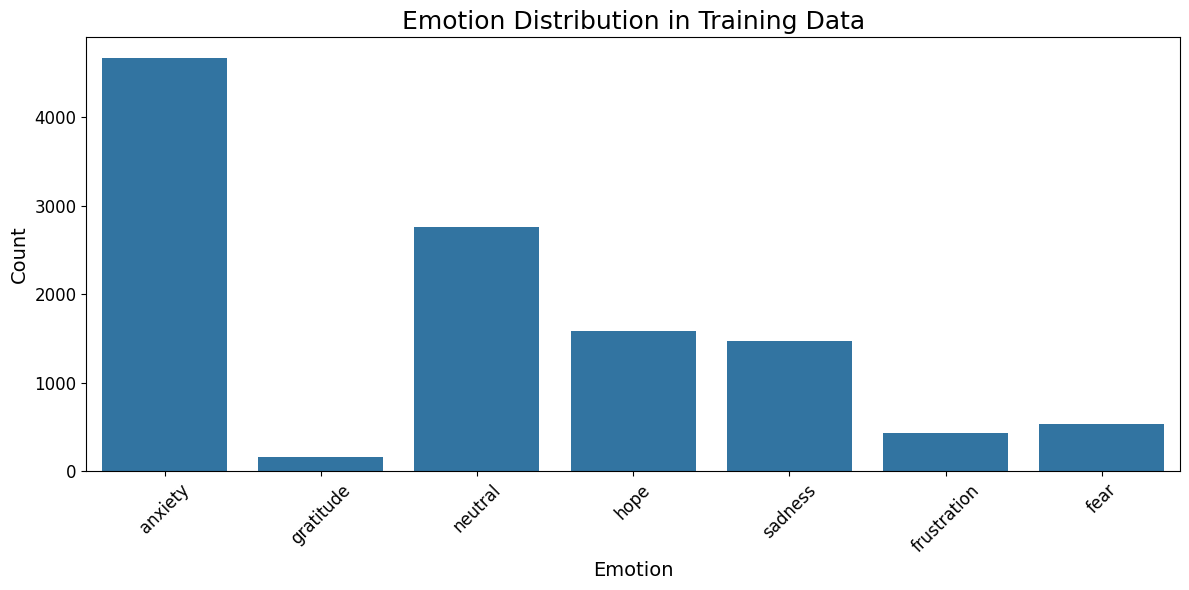

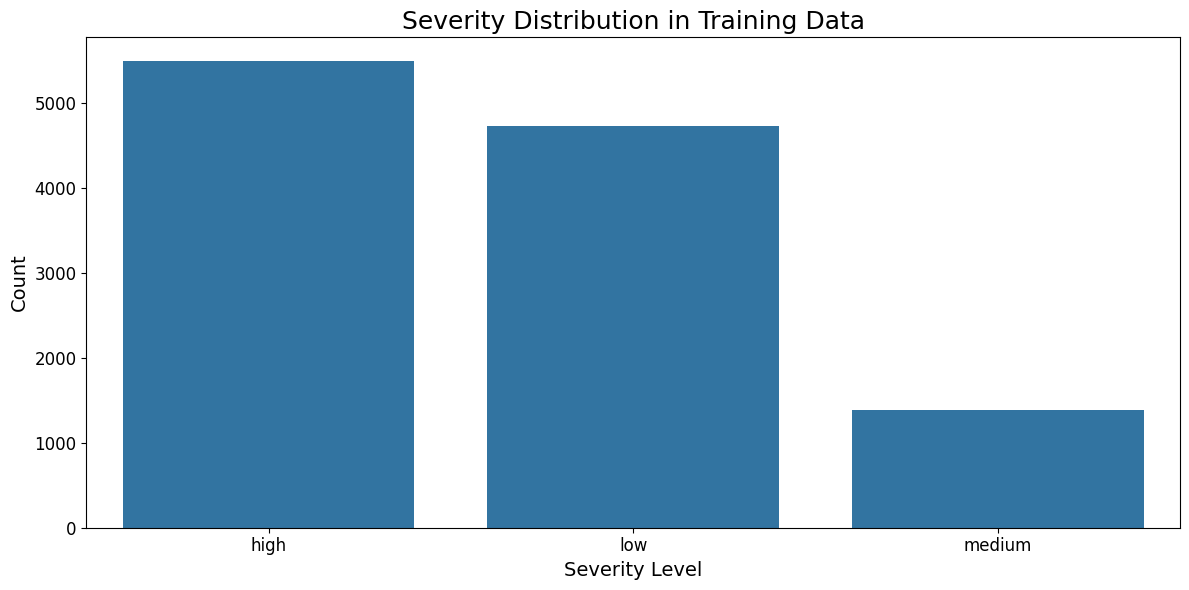

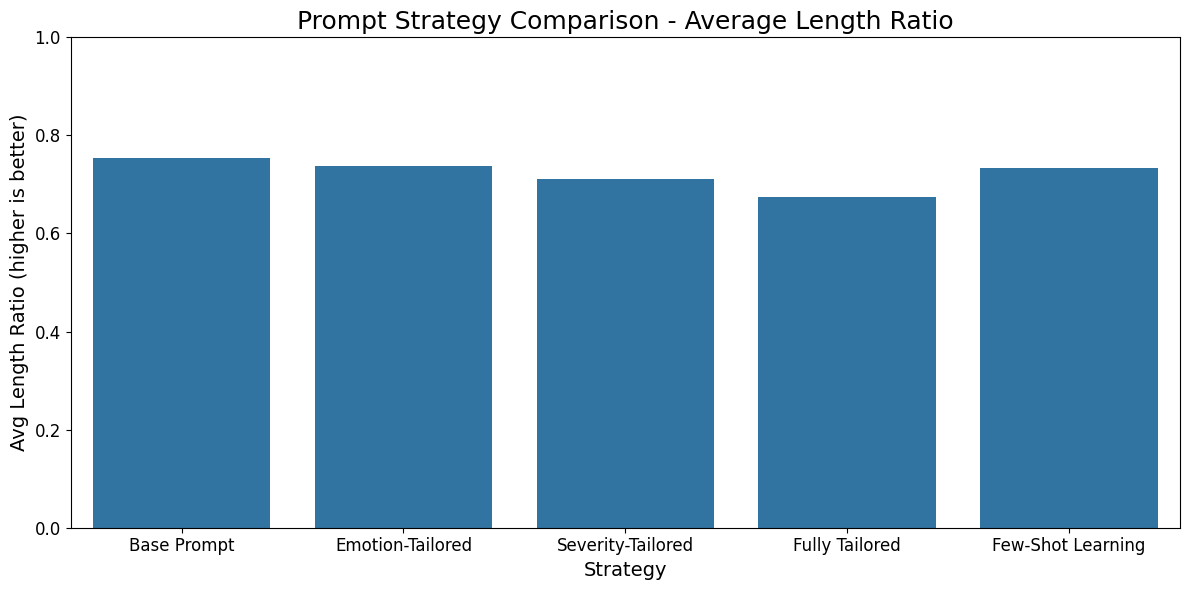

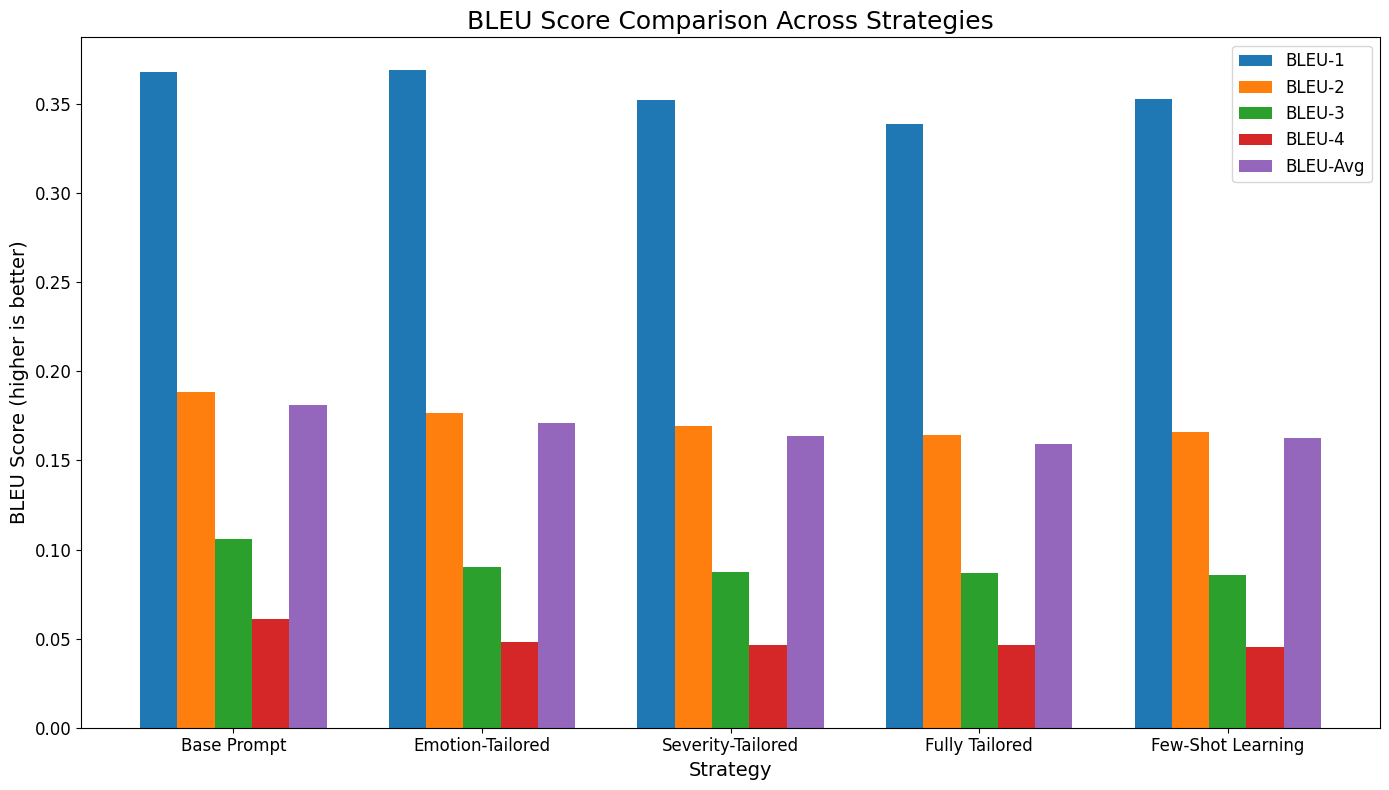

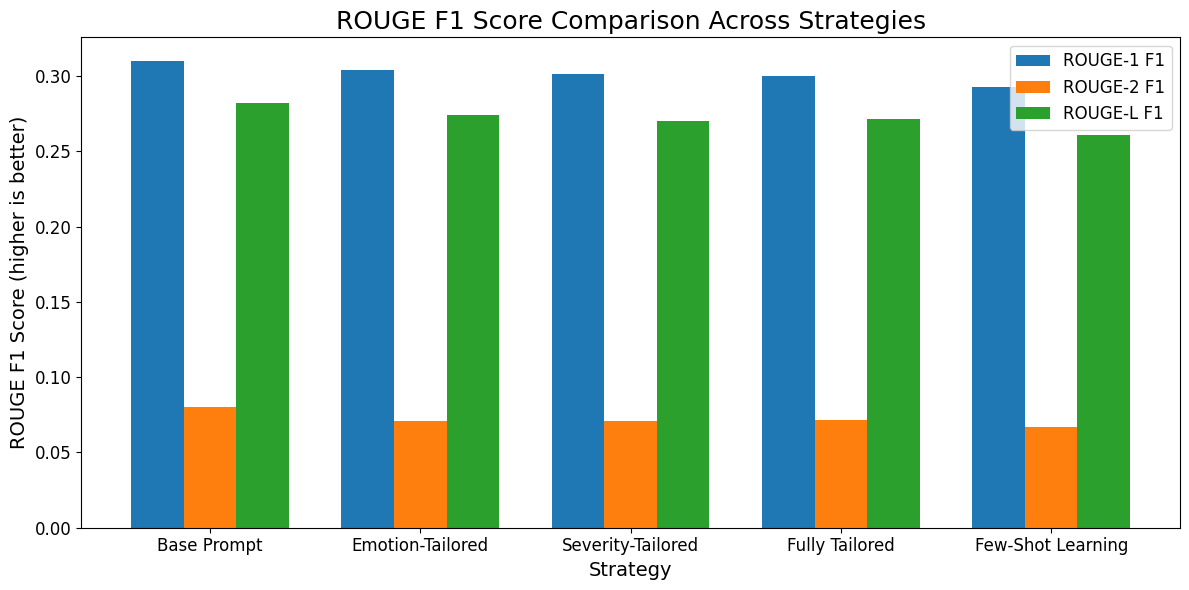

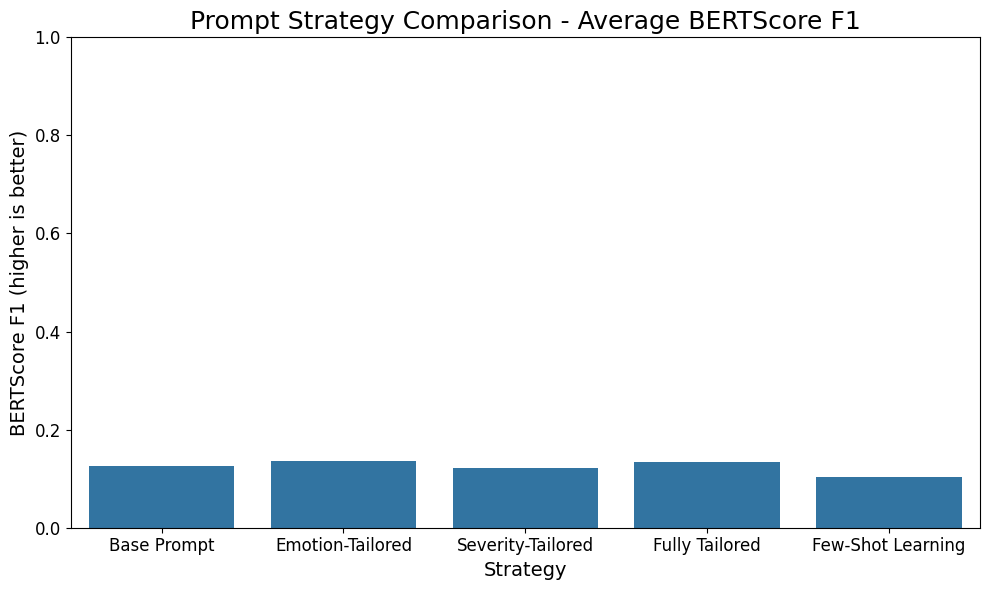

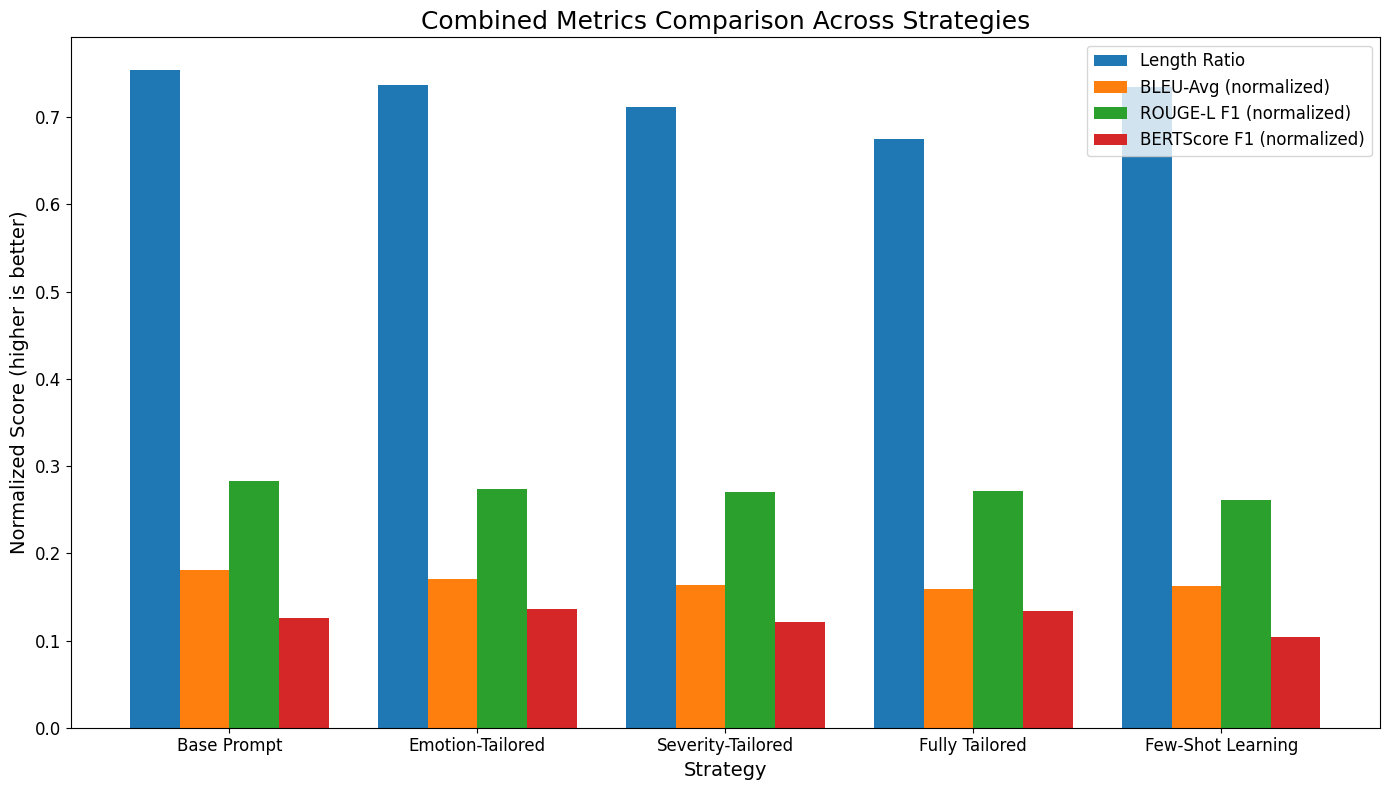

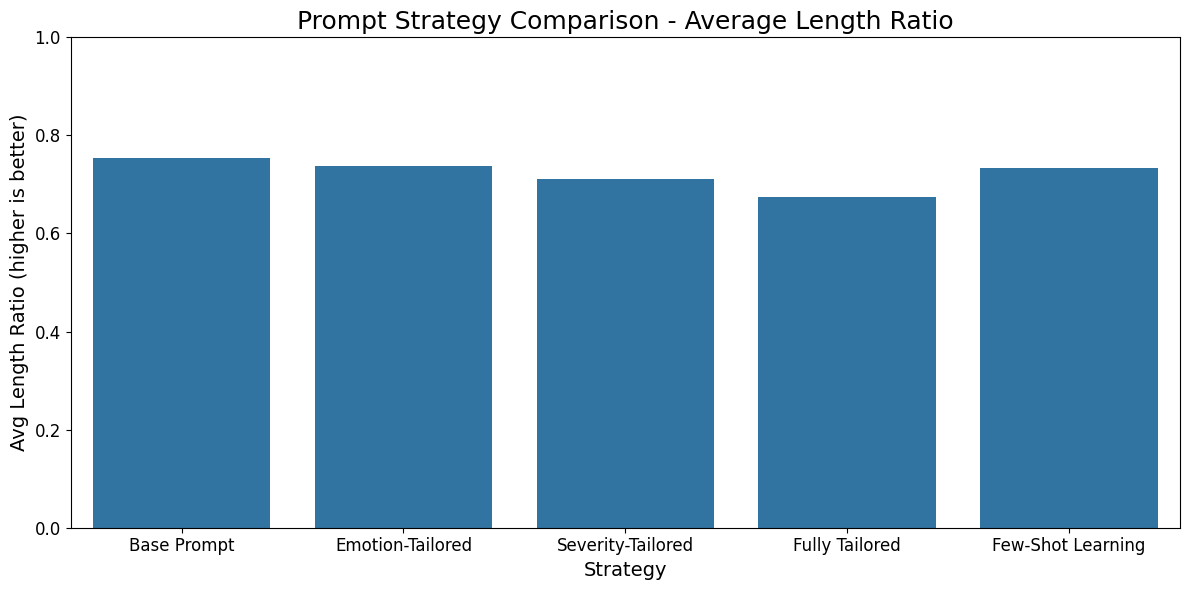

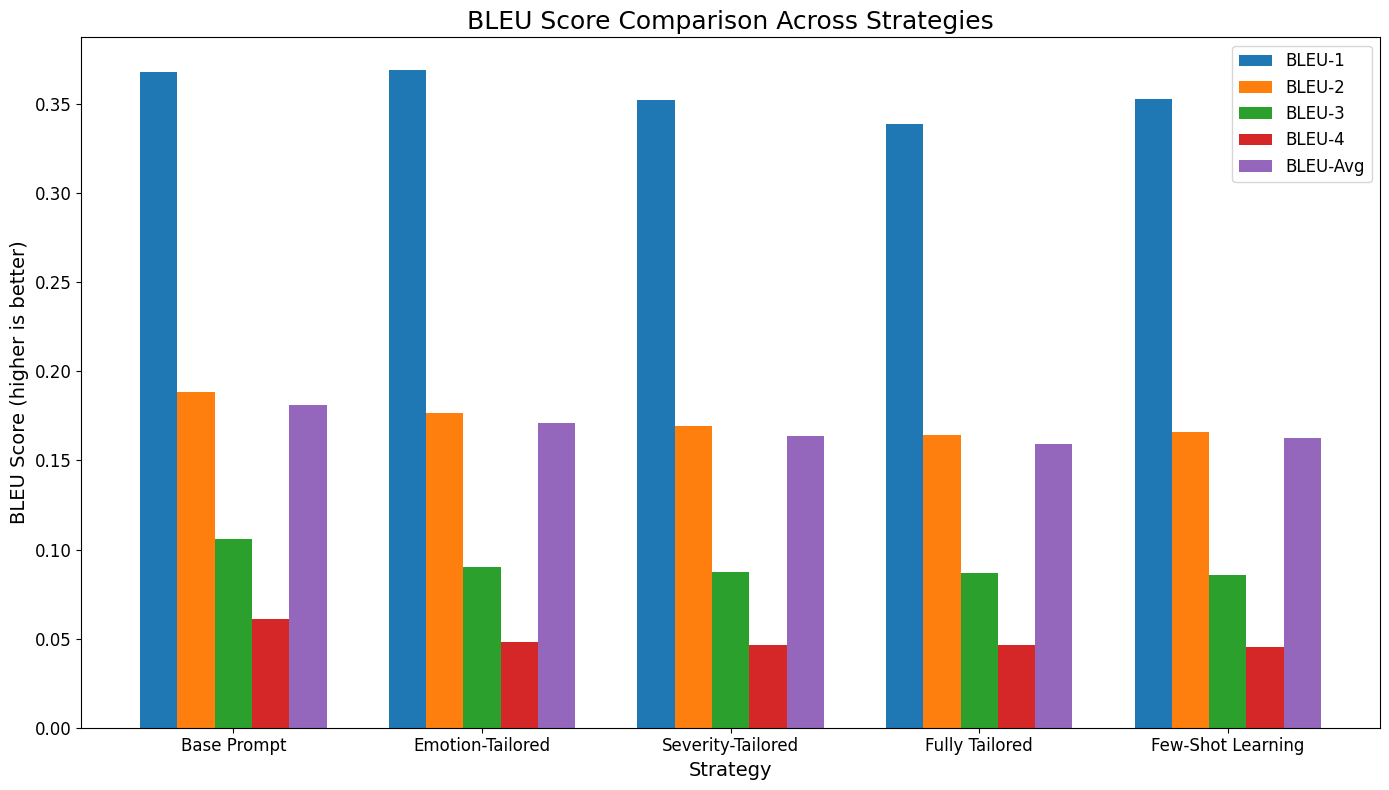

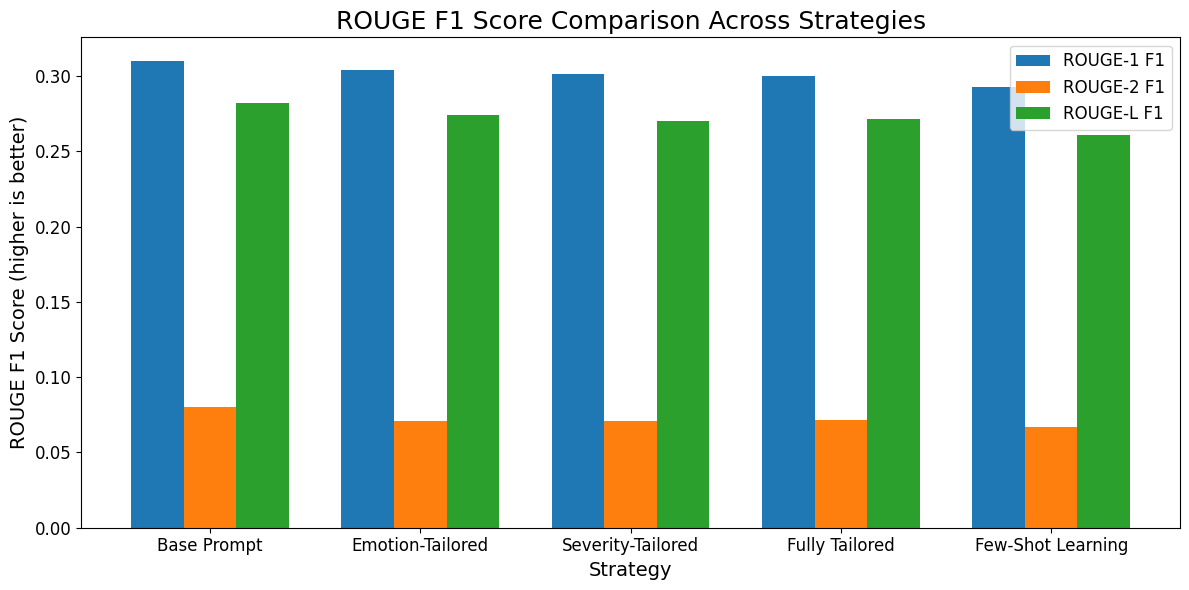

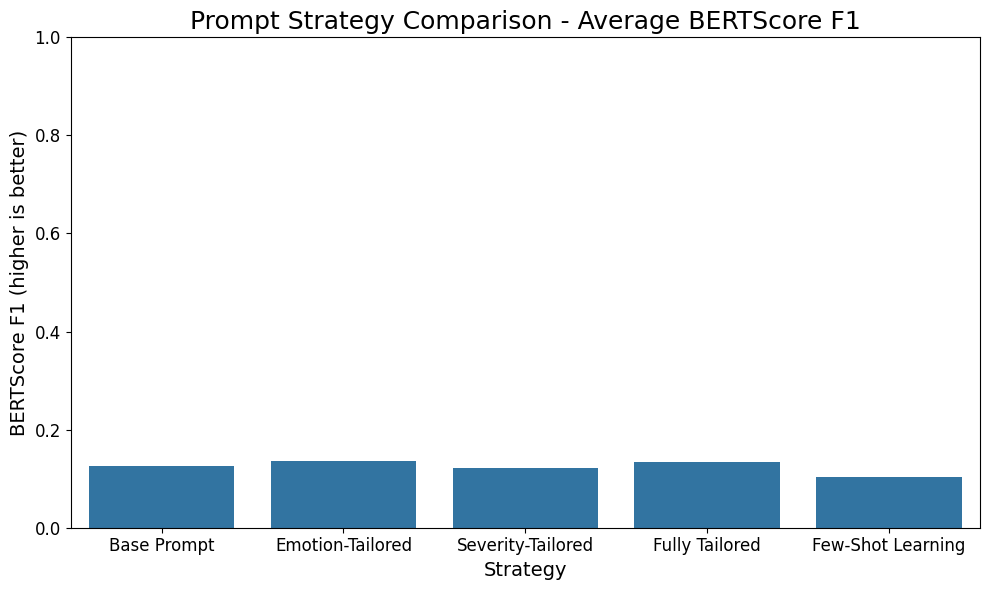

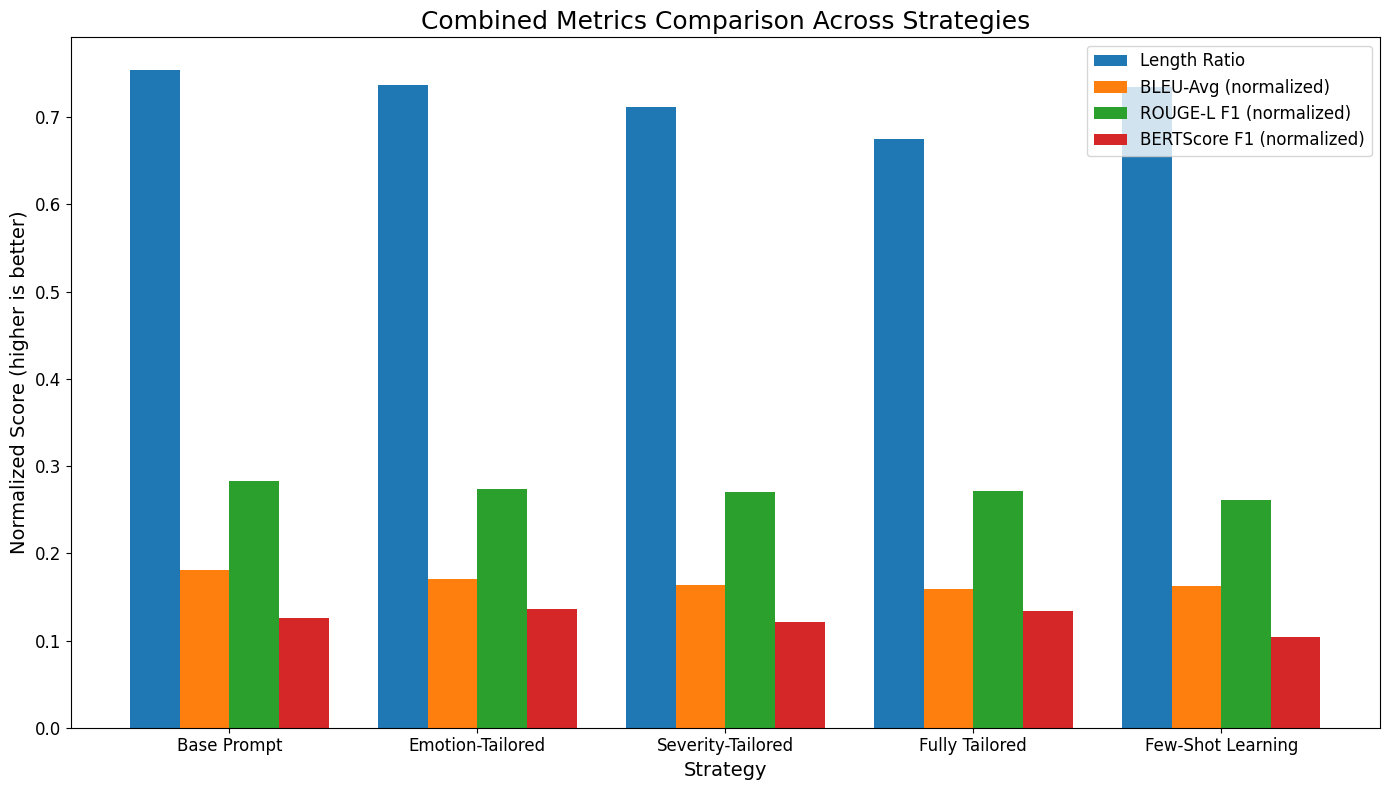

In [67]:
result = run_sonar_prompt_engineering_workflow(train_clean, val_clean, test_clean)

print(f"Workflow status: {result['status']}")
if result['status'] == 'success':
    print("Outputs:")
    for key, value in result['outputs'].items():
        print(f"  {key}: {value}")

In [71]:
!zip -r solace-ai.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.05.14/ (stored 0%)
  adding: content/.config/logs/2025.05.14/13.38.05.736741.log (deflated 86%)
  adding: content/.config/logs/2025.05.14/13.37.56.530848.log (deflated 58%)
  adding: content/.config/logs/2025.05.14/13.38.07.566408.log (deflated 58%)
  adding: content/.config/logs/2025.05.14/13.38.16.976468.log (deflated 57%)
  adding: content/.config/logs/2025.05.14/13.38.17.706556.log (deflated 56%)
  a